In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Paths in Google Drive
DATASET_PATH = "/content/drive/MyDrive/kaggle/audio_leo_datasets"
CSV_PATH     = DATASET_PATH + "/UrbanSound8K.csv"

# Your saved models
OUTPUT_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs"
FINAL_MODEL_PATH = OUTPUT_PATH + "/final_hybrid_cnn_qnn_model.pth"
BEST_MODEL_PATH  = OUTPUT_PATH + "/hybrid_cnn_qnn_best.pth"

print(DATASET_PATH)
print(CSV_PATH)
print(FINAL_MODEL_PATH)


/content/drive/MyDrive/kaggle/audio_leo_datasets
/content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv
/content/drive/MyDrive/kaggle/audio_leo_outputs/final_hybrid_cnn_qnn_model.pth


In [ ]:
!pip install -q pennylane pennylane-lightning[gpu] librosa soundfile torchaudio matplotlib seaborn tqdm gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 142.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.3/911.3 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 12.9 MB/s eta 0:00:00


# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
chrisfilo_urbansound8k_path = kagglehub.dataset_download('chrisfilo/urbansound8k')
leoashi_audio_leo_path = kagglehub.notebook_output_download('leoashi/audio-leo')

print('Data source import complete.')


# here zero

In [ ]:
!pip install pennylane pennylane-lightning
!pip install librosa soundfile
!pip install torchaudio
!pip install audiomentations
!pip install matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


In [ ]:
!pip install "pennylane-lightning[gpu]"

In [ ]:
# Cell 1: Imports

import os
import random
import math

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Optional: if torchaudio is available (Kaggle usually has it)
try:
    import torchaudio
    from torchaudio import transforms as T
    HAS_TORCHAUDIO = True
except ImportError:
    HAS_TORCHAUDIO = False
    print("torchaudio not found. Please install torchaudio for audio processing.")

# PennyLane for quantum layers
import pennylane as qml

print("Torch version:", torch.__version__)
print("PennyLane version:", qml.__version__)
print("Has torchaudio:", HAS_TORCHAUDIO)


Torch version: 2.9.0+cu126
PennyLane version: 0.43.1
Has torchaudio: True


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
# Cell 2: Device selection (GPU if available, else CPU)

if torch.cuda.is_available():
    torch_device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    torch_device = torch.device("cpu")
    device_name = "CPU"

print(f"Torch device: {torch_device} ({device_name})")


Torch device: cuda (Tesla T4)


In [ ]:
# Cell 3: Global config and reproducibility

RANDOM_SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS_BASELINE = 5  # we can increase later
NUM_CLASSES = 10         # UrbanSound8K has 10 target classes

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)

print("Random seed set to:", RANDOM_SEED)
print("Batch size:", BATCH_SIZE)
print("Learning rate:", LEARNING_RATE)
print("Epochs (baseline):", NUM_EPOCHS_BASELINE)


In [ ]:
import torch

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("GPU Count:", torch.cuda.device_count())
    print("Torch device:", torch.device("cuda"))
else:
    print("Running on CPU")


In [ ]:
os.listdir("/kaggle/input")


In [ ]:
# Cell 4 (fixed): Detect correct UrbanSound8K structure

DATA_ROOT = "/kaggle/input/urbansound8k"

# CASE 1 — Standard structure (metadata/ + audio/)
csv_path_1 = os.path.join(DATA_ROOT, "metadata", "UrbanSound8K.csv")
audio_root_1 = os.path.join(DATA_ROOT, "audio")

# CASE 2 — Flat structure (CSV + folds directly inside root)
csv_path_2 = os.path.join(DATA_ROOT, "UrbanSound8K.csv")
fold1_path  = os.path.join(DATA_ROOT, "fold1")

# Logic to detect which one is present
if os.path.exists(csv_path_1) and os.path.exists(audio_root_1):
    print("Detected standard UrbanSound8K structure.")
    METADATA_CSV = csv_path_1
    AUDIO_ROOT   = audio_root_1

elif os.path.exists(csv_path_2):
    print("Detected flat UrbanSound8K structure.")
    METADATA_CSV = csv_path_2
    AUDIO_ROOT   = DATA_ROOT  # folds are directly here

else:
    raise FileNotFoundError("Could not detect UrbanSound8K structure.")# Cell 5: Audio + spectrogram hyperparameters

SAMPLE_RATE = 16000       # we will resample all audio to this
DURATION    = 4.0         # seconds; UrbanSound8K clips are <= 4s
NUM_SAMPLES = int(SAMPLE_RATE * DURATION)

N_MELS      = 64          # number of Mel bands
N_FFT       = 1024
HOP_LENGTH  = 512

print("Sample rate:", SAMPLE_RATE)
print("Target duration (s):", DURATION)
print("Target samples per clip:", NUM_SAMPLES)
print("Mel bins:", N_MELS)


print("METADATA_CSV:", METADATA_CSV)
print("AUDIO_ROOT:", AUDIO_ROOT)
print("CSV exists:", os.path.exists(METADATA_CSV))


In [ ]:
# Cell 5: Audio + spectrogram hyperparameters

SAMPLE_RATE = 16000       # we will resample all audio to this
DURATION    = 4.0         # seconds; UrbanSound8K clips are <= 4s
NUM_SAMPLES = int(SAMPLE_RATE * DURATION)

N_MELS      = 64          # number of Mel bands
N_FFT       = 1024
HOP_LENGTH  = 512

print("Sample rate:", SAMPLE_RATE)
print("Target duration (s):", DURATION)
print("Target samples per clip:", NUM_SAMPLES)
print("Mel bins:", N_MELS)


In [ ]:
# Cell 6: Audio loading and log-Mel spectrogram transform

import librosa
import torch.nn.functional as F

def load_audio(path, target_sr=SAMPLE_RATE):
    """Load audio file and return mono waveform tensor at target_sr."""
    if HAS_TORCHAUDIO:
        waveform, sr = torchaudio.load(path)  # (channels, samples)
        # convert to mono by averaging channels if needed
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
            waveform = resampler(waveform)
        return waveform.squeeze(0), target_sr  # (samples,), sr
    else:
        # librosa fallback
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        return torch.tensor(y, dtype=torch.float32), target_sr

def pad_or_trim(waveform, num_samples=NUM_SAMPLES):
    """Pad with zeros or trim to a fixed number of samples."""
    length = waveform.shape[-1]
    if length < num_samples:
        pad_amount = num_samples - length
        waveform = F.pad(waveform, (0, pad_amount))
    elif length > num_samples:
        waveform = waveform[:num_samples]
    return waveform

# Pre-build a MelSpectrogram transform if torchaudio is available
if HAS_TORCHAUDIO:
    mel_transform = T.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
else:
    mel_transform = None  # we'll use librosa.melspectrogram later if needed

def waveform_to_logmel(waveform):
    """Convert 1D waveform tensor -> log-Mel spectrogram tensor [1, n_mels, time]."""
    waveform = waveform.unsqueeze(0)  # [1, samples]
    if HAS_TORCHAUDIO and mel_transform is not None:
        mel = mel_transform(waveform)  # [1, n_mels, time]
        mel = torch.clamp(mel, min=1e-9).log()
        return mel
    else:
        # librosa fallback
        y = waveform.squeeze(0).cpu().numpy()
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
        )
        mel = np.log(np.clip(mel, a_min=1e-9, a_max=None))
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # [1, n_mels, time]
        return mel


In [ ]:
# Cell 7: UrbanSoundDataset class

import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, csv_path, audio_root, folds=[1], transform=None):
        """
        csv_path: path to UrbanSound8K.csv
        audio_root: folder where fold1/, fold2/, ... exist
        folds: list of fold numbers to include (e.g. [1,2,3,4])
        transform: function to apply to waveform (e.g., log-Mel)
        """
        self.meta = pd.read_csv(csv_path)
        self.audio_root = audio_root
        self.folds = folds
        self.transform = transform

        # Filter rows by fold list
        self.meta = self.meta[self.meta['fold'].isin(folds)]
        self.meta = self.meta.reset_index(drop=True)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        fold = f"fold{row['fold']}"
        file_path = os.path.join(self.audio_root, fold, row['slice_file_name'])

        label = int(row['classID'])

        # Load audio
        waveform, sr = load_audio(file_path)

        # Fix length
        waveform = pad_or_trim(waveform)

        # Transform to log-Mel if provided
        if self.transform:
            mel = self.transform(waveform)
            return mel, label

        # Otherwise return raw waveform
        return waveform, label


In [ ]:
# Cell 8: Test dataset with a single sample

# use fold 1 only for testing
test_dataset = UrbanSoundDataset(
    csv_path=METADATA_CSV,
    audio_root=AUDIO_ROOT,
    folds=[1],
    transform=waveform_to_logmel
)

mel, label = test_dataset[0]

print("Mel shape:", mel.shape)   # expect [1, N_MELS, time_frames]
print("Label:", label)
print("Time frames (mel width):", mel.shape[-1])


In [ ]:
# Cell 9 (REPLACE): Lighter train and validation datasets

# Use fewer folds to speed up training
train_folds = [1, 2, 3, 4]   # was [1..8]
val_folds   = [5]            # was [9]

train_dataset = UrbanSoundDataset(
    csv_path=METADATA_CSV,
    audio_root=AUDIO_ROOT,
    folds=train_folds,
    transform=waveform_to_logmel
)

val_dataset = UrbanSoundDataset(
    csv_path=METADATA_CSV,
    audio_root=AUDIO_ROOT,
    folds=val_folds,
    transform=waveform_to_logmel
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


In [ ]:
# Cell 10 (REPLACE): DataLoaders for new train/val splits

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Quick check
mel_batch, label_batch = next(iter(train_loader))
print("Batch mel shape:", mel_batch.shape)
print("Batch labels shape:", label_batch.shape)
print("Example label:", label_batch[0].item())


In [ ]:
# Cell 11: Audio CNN backbone + baseline classifier

class AudioCNNBackbone(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 16, 32, ~63]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 32, 16, ~31]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 64, 8,  ~15]
        )

        # Make output feature size independent of exact time dimension
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # -> [B, 64, 1, 1]

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # [B, 64]
        return x  # embedding


class BaselineAudioCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, in_channels=1):
        super().__init__()
        self.backbone = AudioCNNBackbone(in_channels=in_channels)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 1, 64, T]
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits


# Instantiate model and move to device
baseline_model = BaselineAudioCNN(num_classes=NUM_CLASSES).to(torch_device)

total_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)
print(baseline_model)
print(f"Trainable parameters: {total_params:,}")
# Cell 12: Training and evaluation functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in dataloader:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in dataloader:
        mel = mel.to(device)
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# Cell 12: tqdm-based training & evaluation helpers (Keras-like live progress)

from tqdm.auto import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch=None, num_epochs=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    desc = f"Train"
    if epoch is not None and num_epochs is not None:
        desc = f"Train [{epoch}/{num_epochs}]"

    progress_bar = tqdm(dataloader, desc=desc, leave=False)

    for mel, labels in progress_bar:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        # live metrics on the bar
        current_loss = running_loss / total
        current_acc = correct / total
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device, epoch=None, num_epochs=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    desc = f"Val"
    if epoch is not None and num_epochs is not None:
        desc = f"Val   [{epoch}/{num_epochs}]"

    progress_bar = tqdm(dataloader, desc=desc, leave=False)

    for mel, labels in progress_bar:
        mel = mel.to(device)
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        current_loss = running_loss / total
        current_acc = correct / total
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Cell 13: Train baseline CNN for a few epochs (with live tqdm bars)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS_BASELINE + 1):
    train_loss, train_acc = train_one_epoch(
        baseline_model, train_loader, criterion, optimizer, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_BASELINE
    )
    val_loss, val_acc = evaluate(
        baseline_model, val_loader, criterion, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_BASELINE
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(baseline_model.state_dict(), "baseline_audio_cnn.pth")

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

print("Best val acc:", best_val_acc)


In [ ]:
# Cell A: DataLoaders (fast version with workers again)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,      # back to 2 workers for speed
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
# Cell B: Training and evaluation with simple live progress

def train_one_epoch(model, dataloader, criterion, optimizer, device,
                    epoch=None, num_epochs=None, log_interval=20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    num_batches = len(dataloader)

    for batch_idx, (mel, labels) in enumerate(dataloader, start=1):
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        # live progress line
        if batch_idx % log_interval == 0 or batch_idx == num_batches:
            cur_loss = running_loss / total
            cur_acc  = correct / total
            if epoch is not None and num_epochs is not None:
                prefix = f"Epoch {epoch}/{num_epochs} "
            else:
                prefix = ""
            print(
                f"{prefix}[{batch_idx:3d}/{num_batches:3d}] "
                f"loss={cur_loss:.4f} acc={cur_acc:.4f}",
                end="\r"
            )

    print()  # newline after last batch
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device,
             epoch=None, num_epochs=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    num_batches = len(dataloader)

    for batch_idx, (mel, labels) in enumerate(dataloader, start=1):
        mel = mel.to(device)
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# Cell C: Train baseline CNN again (fast + live progress)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS_BASELINE + 1):
    train_loss, train_acc = train_one_epoch(
        baseline_model, train_loader, criterion, optimizer, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_BASELINE, log_interval=20
    )
    val_loss, val_acc = evaluate(
        baseline_model, val_loader, criterion, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_BASELINE
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(baseline_model.state_dict(), "baseline_audio_cnn.pth")

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

print("Best val acc:", best_val_acc)


In [ ]:
# Cell 14 (updated): QNN with automatic GPU/CPU device selection

N_QUBITS = 8
N_Q_LAYERS = 3

def create_qml_device():
    """Create a PennyLane device, preferring GPU if available."""
    # If torch sees a CUDA device, try to use lightning.gpu
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu (GPU)")
            return dev
        except Exception as e:
            print("Could not use lightning.gpu, falling back to lightning.qubit (CPU).")
            print("Reason:", repr(e))

    # Fallback: fast CPU simulator
    dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
    print("PennyLane device: lightning.qubit (CPU)")
    return dev


def qnn_circuit(inputs, weights):
    """Quantum circuit with angle embedding + variational layers."""
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))

    for l in range(N_Q_LAYERS):
        # single-qubit rotations
        for w in range(N_QUBITS):
            qml.Rot(
                weights[l, w, 0],
                weights[l, w, 1],
                weights[l, w, 2],
                wires=w,
            )
        # ring entanglement
        for w in range(N_QUBITS):
            qml.CNOT(wires=[w, (w + 1) % N_QUBITS])

    return [qml.expval(qml.PauliZ(w)) for w in range(N_QUBITS)]


# Wrap as TorchLayer factory
weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    layer = qml.qnn.TorchLayer(qnode, weight_shapes)
    return layer


# Quick sanity check
qnn_layer = create_qnn_layer()
x_test = torch.randn(4, N_QUBITS)
y_test = qnn_layer(x_test)

print("QNN input shape:", x_test.shape)
print("QNN output shape:", y_test.shape)


In [ ]:
# Cell 15: Hybrid Audio CNN + QNN model (Level 4 parallel heads)

class HybridAudioCNNQNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, in_channels=1,
                 alpha=1.0, beta=1.0):
        super().__init__()
        self.backbone = AudioCNNBackbone(in_channels=in_channels)

        emb_dim = 64  # backbone outputs 64-dim features

        # Classical head
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

        # Quantum head
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        # Combination weights
        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        # x: [B, 1, 64, T]
        features = self.backbone(x)          # [B, 64]

        # Classical path
        logits_classical = self.classical_head(features)  # [B, C]

        # Quantum path: compress -> tanh -> QNN -> linear
        q_inputs = torch.tanh(self.fc_to_q(features))     # [B, 8] in [-1, 1]
        q_outputs = self.qnn(q_inputs)                    # [B, 8]
        logits_quantum = self.quantum_head(q_outputs)     # [B, C]

        # Combine
        logits = self.alpha * logits_classical + self.beta * logits_quantum

        if return_heads:
            return logits, logits_classical, logits_quantum
        return logits


# Instantiate hybrid model
hybrid_model = HybridAudioCNNQNN(num_classes=NUM_CLASSES).to(torch_device)

total_params_hybrid = sum(p.numel() for p in hybrid_model.parameters() if p.requires_grad)
print(hybrid_model)
print(f"Hybrid model trainable parameters: {total_params_hybrid:,}")


# Cell 16: Train hybrid CNN + QNN model

NUM_EPOCHS_HYBRID = 3   # start small; can increase later
HYBRID_LR = 5e-4        # often a bit smaller than baseline LR

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=HYBRID_LR)

best_val_acc_hybrid = 0.0

for epoch in range(1, NUM_EPOCHS_HYBRID + 1):
    train_loss, train_acc = train_one_epoch(
        hybrid_model, train_loader, criterion, optimizer_hybrid, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_HYBRID, log_interval=20
    )
    val_loss, val_acc = evaluate(
        hybrid_model, val_loader, criterion, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_HYBRID
    )

    if val_acc > best_val_acc_hybrid:
        best_val_acc_hybrid = val_acc
        torch.save(hybrid_model.state_dict(), "hybrid_audio_cnn_qnn.pth")

    print(
        f"[HYBRID] Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

print("Best hybrid val acc:", best_val_acc_hybrid)


In [ ]:
# Cell 17: Bigger CNN backbone + larger hybrid model

class AudioCNNBackboneBig(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 32, 32, ~63]
            nn.Dropout(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 64, 16, ~31]
            nn.Dropout(0.15),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 128, 8, ~15]
            nn.Dropout(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   # [B, 256, 4, ~7]
            nn.Dropout(0.3),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # -> [B, 256, 1, 1]

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # [B, 256]
        return x


class HybridAudioCNNQNNBig(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, in_channels=1,
                 alpha=1.0, beta=1.0):
        super().__init__()
        self.backbone = AudioCNNBackboneBig(in_channels=in_channels)

        emb_dim = 256  # bigger embedding

        # Classical head: a bit larger MLP
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

        # Quantum head: compress to N_QUBITS, then QNN, then FC
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        features = self.backbone(x)                 # [B, 256]

        # Classical branch
        logits_classical = self.classical_head(features)  # [B, C]

        # Quantum branch
        q_inputs = torch.tanh(self.fc_to_q(features))      # [B, N_QUBITS]
        q_outputs = self.qnn(q_inputs)                    # [B, N_QUBITS]
        logits_quantum = self.quantum_head(q_outputs)     # [B, C]

        logits = self.alpha * logits_classical + self.beta * logits_quantum

        if return_heads:
            return logits, logits_classical, logits_quantum
        return logits


# Instantiate big hybrid model
hybrid_model_big = HybridAudioCNNQNNBig(num_classes=NUM_CLASSES).to(torch_device)

total_params_big = sum(p.numel() for p in hybrid_model_big.parameters() if p.requires_grad)
print(hybrid_model_big)
print(f"Big hybrid model trainable parameters: {total_params_big:,}")


In [ ]:
# Cell 18: Test training run for big hybrid CNN + QNN

NUM_EPOCHS_HYBRID_BIG = 3
HYBRID_BIG_LR = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer_hybrid_big = optim.Adam(hybrid_model_big.parameters(), lr=HYBRID_BIG_LR)

best_val_acc_hybrid_big = 0.0

for epoch in range(1, NUM_EPOCHS_HYBRID_BIG + 1):
    train_loss, train_acc = train_one_epoch(
        hybrid_model_big, train_loader, criterion, optimizer_hybrid_big, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_HYBRID_BIG, log_interval=20
    )
    val_loss, val_acc = evaluate(
        hybrid_model_big, val_loader, criterion, torch_device,
        epoch=epoch, num_epochs=NUM_EPOCHS_HYBRID_BIG
    )

    if val_acc > best_val_acc_hybrid_big:
        best_val_acc_hybrid_big = val_acc
        torch.save(hybrid_model_big.state_dict(), "hybrid_audio_cnn_qnn_big.pth")

    print(
        f"[HYBRID-BIG] Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

print("Best big hybrid val acc:", best_val_acc_hybrid_big)


In [ ]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Hybrid big backbone device:", next(hybrid_model_big.backbone.parameters()).device)

# Correct QNN info
dev = hybrid_model_big.qnn.qnode.device
print("QNN device class:", type(dev))
print("QNN device name:", dev.name)
print("QNN device wires:", dev.wires)


In [ ]:
# Cell 20: Full-training config + autosave / resume helpers

FULL_NUM_EPOCHS = 15          # you can increase later if you want
FULL_LR = 5e-4                 # learning rate for full training

CKPT_PATH = "/kaggle/working/hybrid_big_ckpt.pth"
HISTORY_CSV = "/kaggle/working/hybrid_big_history.csv"

print("Checkpoint path:", CKPT_PATH)
print("History CSV path:", HISTORY_CSV)


def save_checkpoint(model, optimizer, epoch, best_val_acc, history, path=CKPT_PATH):
    """Save model, optimizer, epoch, best val acc, and history."""
    ckpt = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "history": history,
    }
    torch.save(ckpt, path)
    # Also save history to CSV for easy inspection
    import pandas as pd
    df = pd.DataFrame(history)
    df.to_csv(HISTORY_CSV, index=False)
    print(f"[AUTOSAVE] Saved checkpoint at epoch {epoch} to {path}")


def load_checkpoint_if_exists(model, optimizer, path=CKPT_PATH):
    """Load checkpoint if it exists; otherwise start from scratch."""
    if os.path.exists(path):
        ckpt = torch.load(path, map_location=torch_device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        start_epoch = ckpt["epoch"] + 1
        best_val_acc = ckpt.get("best_val_acc", 0.0)
        history = ckpt.get("history", [])
        print(f"[RESUME] Loaded checkpoint from {path}, starting at epoch {start_epoch}")
    else:
        start_epoch = 1
        best_val_acc = 0.0
        history = []
        print("[RESUME] No checkpoint found, starting from scratch.")
    return start_epoch, best_val_acc, history


In [ ]:
# Cell 21: Full hybrid training with autosave & resume

# Make sure model is on the right device
hybrid_model_big = hybrid_model_big.to(torch_device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid_big = optim.Adam(hybrid_model_big.parameters(), lr=FULL_LR)

# Try to resume from checkpoint if it exists
start_epoch, best_val_acc_hybrid_big, history = load_checkpoint_if_exists(
    hybrid_model_big, optimizer_hybrid_big, CKPT_PATH
)

print(f"Training from epoch {start_epoch} to {FULL_NUM_EPOCHS}")
print(f"Current best val acc: {best_val_acc_hybrid_big:.4f}")

for epoch in range(start_epoch, FULL_NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        hybrid_model_big, train_loader, criterion, optimizer_hybrid_big, torch_device,
        epoch=epoch, num_epochs=FULL_NUM_EPOCHS, log_interval=20
    )
    val_loss, val_acc = evaluate(
        hybrid_model_big, val_loader, criterion, torch_device,
        epoch=epoch, num_epochs=FULL_NUM_EPOCHS
    )

    # Update best and autosave
    if val_acc > best_val_acc_hybrid_big:
        best_val_acc_hybrid_big = val_acc

    # Append to history
    history.append({
        "epoch": epoch,
        "train_loss": float(train_loss),
        "train_acc": float(train_acc),
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "best_val_acc_so_far": float(best_val_acc_hybrid_big),
    })

    save_checkpoint(
        hybrid_model_big, optimizer_hybrid_big,
        epoch, best_val_acc_hybrid_big, history, CKPT_PATH
    )

    print(
        f"[FULL-HYBRID] Epoch {epoch:02d}/{FULL_NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
        f"Best Val Acc: {best_val_acc_hybrid_big:.4f}"
    )

print("=== Full training finished ===")
print("Best big hybrid val acc:", best_val_acc_hybrid_big)
print("Checkpoint saved at:", CKPT_PATH)
print("History CSV saved at:", HISTORY_CSV)


In [ ]:
import os

print(os.listdir("/kaggle/working"))
print("Checkpoint exists:",
      os.path.exists("/kaggle/working/hybrid_big_ckpt.pth"))
print("History exists:",
      os.path.exists("/kaggle/working/hybrid_big_history.csv"))


In [ ]:
import shutil

BEST_MODEL_PATH = "/kaggle/working/hybrid_big_best.pth"
shutil.copy("/kaggle/working/hybrid_big_ckpt.pth", BEST_MODEL_PATH)
print("Copied best model to:", BEST_MODEL_PATH)


In [ ]:
from IPython.display import FileLink

print("Best model:")
display(FileLink("/kaggle/working/hybrid_big_best.pth"))

print("Training history:")
display(FileLink("/kaggle/working/hybrid_big_history.csv"))


# here

In [ ]:
# Big CNN backbone with dynamic flatten size
class AudioCNNBackboneBig(nn.Module):
    def __init__(self, in_channels=1, input_shape=(1, 64, 126)):
        super().__init__()

        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # --- compute flatten dim from a fake mel sample ---
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)  # (B, C, n_mels, time)
            out = self.conv(dummy)
            flat_dim = out.view(1, -1).shape[1]

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.embedding(x)
        return x  # [batch, 128]


In [ ]:
class HybridAudioCNNQNN_Big(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super().__init__()

        self.backbone = AudioCNNBackboneBig(in_channels=in_channels)
        emb_dim = 128          # from backbone
        self.n_qubits = 8      # quantum wires

        # --- NEW: projection 128 -> 8 for QNN ---
        self.qproj = nn.Linear(emb_dim, self.n_qubits)

        # Classical head
        self.class_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 128),    # <-- use 4096 instead of 10752
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # QNN setup
        weight_shapes = {"weights": (2, self.n_qubits, 3)}
        dev = qml.device("lightning.gpu", wires=self.n_qubits)

        @qml.qnode(dev, interface="torch")
        def qnode(inputs, weights):
            # inputs has shape (n_qubits,)
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.qnn = qml.qnn.TorchLayer(qnode, weight_shapes)

        self.quantum_head = nn.Linear(self.n_qubits, num_classes)

    def forward(self, x):
        emb = self.backbone(x)           # [B, 128]

        # classical
        out_classical = self.class_head(emb)

        # quantum path: 128 -> 8 -> QNN
        q_in = self.qproj(emb)           # [B, 8]
        q_out = self.qnn(q_in)           # [B, 8]
        out_quantum = self.quantum_head(q_out)

        return (out_classical + out_quantum) / 2


In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 10
hybrid_model_big = HybridAudioCNNQNN_Big(num_classes=num_classes).to(torch_device)
print("Device:", torch_device)


In [ ]:
import torch
import torchaudio
import torchvision
import pandas as pd
import numpy as np
import pennylane as qml
from torch.utils.data import Dataset, DataLoader


In [ ]:
import os
print(os.listdir("/kaggle/input/urbansound8k"))


In [ ]:
import os

DATA_ROOT = "/kaggle/input/urbansound8k"

METADATA_CSV = os.path.join(DATA_ROOT, "UrbanSound8K.csv")
AUDIO_ROOT   = DATA_ROOT   # <-- folds are directly here

print("CSV exists:", METADATA_CSV, os.path.exists(METADATA_CSV))
print("Audio root exists:", AUDIO_ROOT, os.path.exists(AUDIO_ROOT))


In [ ]:
# Cell 6: Audio loading and log-Mel spectrogram transform

import librosa
import torch.nn.functional as F

def load_audio(path, target_sr=SAMPLE_RATE):
    """Load audio file and return mono waveform tensor at target_sr."""
    if HAS_TORCHAUDIO:
        waveform, sr = torchaudio.load(path)  # (channels, samples)
        # convert to mono by averaging channels if needed
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
            waveform = resampler(waveform)
        return waveform.squeeze(0), target_sr  # (samples,), sr
    else:
        # librosa fallback
        y, sr = librosa.load(path, sr=target_sr, mono=True)
        return torch.tensor(y, dtype=torch.float32), target_sr

def pad_or_trim(waveform, num_samples=NUM_SAMPLES):
    """Pad with zeros or trim to a fixed number of samples."""
    length = waveform.shape[-1]
    if length < num_samples:
        pad_amount = num_samples - length
        waveform = F.pad(waveform, (0, pad_amount))
    elif length > num_samples:
        waveform = waveform[:num_samples]
    return waveform

# Pre-build a MelSpectrogram transform if torchaudio is available
if HAS_TORCHAUDIO:
    mel_transform = T.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
else:
    mel_transform = None  # we'll use librosa.melspectrogram later if needed

def waveform_to_logmel(waveform):
    """Convert 1D waveform tensor -> log-Mel spectrogram tensor [1, n_mels, time]."""
    waveform = waveform.unsqueeze(0)  # [1, samples]
    if HAS_TORCHAUDIO and mel_transform is not None:
        mel = mel_transform(waveform)  # [1, n_mels, time]
        mel = torch.clamp(mel, min=1e-9).log()
        return mel
    else:
        # librosa fallback
        y = waveform.squeeze(0).cpu().numpy()
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
        )
        mel = np.log(np.clip(mel, a_min=1e-9, a_max=None))
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # [1, n_mels, time]
        return mel


In [ ]:
# Cell 7: UrbanSoundDataset class

import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, csv_path, audio_root, folds=[1], transform=None):
        """
        csv_path: path to UrbanSound8K.csv
        audio_root: folder where fold1/, fold2/, ... exist
        folds: list of fold numbers to include (e.g. [1,2,3,4])
        transform: function to apply to waveform (e.g., log-Mel)
        """
        self.meta = pd.read_csv(csv_path)
        self.audio_root = audio_root
        self.folds = folds
        self.transform = transform

        # Filter rows by fold list
        self.meta = self.meta[self.meta['fold'].isin(folds)]
        self.meta = self.meta.reset_index(drop=True)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        fold = f"fold{row['fold']}"
        file_path = os.path.join(self.audio_root, fold, row['slice_file_name'])

        label = int(row['classID'])

        # Load audio
        waveform, sr = load_audio(file_path)

        # Fix length
        waveform = pad_or_trim(waveform)

        # Transform to log-Mel if provided
        if self.transform:
            mel = self.transform(waveform)
            return mel, label

        # Otherwise return raw waveform
        return waveform, label


In [ ]:
# Cell A1 — Datasets

# folds: same split we used before
train_folds = [1, 2, 3, 4]
val_folds   = [5]

train_dataset = UrbanSoundDataset(
    csv_path=METADATA_CSV,
    audio_root=AUDIO_ROOT,
    folds=train_folds,
    transform=waveform_to_logmel
)

val_dataset = UrbanSoundDataset(
    csv_path=METADATA_CSV,
    audio_root=AUDIO_ROOT,
    folds=val_folds,
    transform=waveform_to_logmel
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


In [ ]:
# Cell A2 — Data loaders

BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


In [ ]:
# Cell A3 — Init BIG model
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", torch_device)

num_classes = 10

hybrid_model_big = HybridAudioCNNQNN_Big(num_classes=num_classes).to(torch_device)

print("Model ready on GPU.")



In [ ]:
# Cell A3b — training function
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, num_epochs, log_interval=20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % log_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Batch [{batch_idx+1}/{len(dataloader)}] "
                  f"loss={loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [ ]:
# Cell A3c — evaluation function
def evaluate(model, dataloader, criterion, device, epoch, num_epochs):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"[VAL] Epoch {epoch}/{num_epochs} loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

    return epoch_loss, epoch_acc


In [ ]:
# Cell A4 — Optimizer + Loss
criterion = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(hybrid_model_big.parameters(), lr=5e-4)


In [ ]:
x, y = next(iter(train_loader))
x = x.to(torch_device)
with torch.no_grad():
    emb = hybrid_model_big.backbone(x)
    print("Input batch:", x.shape)
    print("Embedding:", emb.shape)


In [ ]:
# Cell A5 — TRAIN BIG MODEL
import pandas as pd
import csv
import os

NUM_EPOCHS_BIG = 12
CKPT = "/kaggle/working/hybrid_big_ckpt.pth"
BEST = "/kaggle/working/hybrid_big_best.pth"
HISTORY = "/kaggle/working/hybrid_big_history.csv"

best_val_acc = 0

# init CSV
with open(HISTORY, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

print("=== Training Big Hybrid Model ===")

for epoch in range(1, NUM_EPOCHS_BIG + 1):

    train_loss, train_acc = train_one_epoch(
        hybrid_model_big, train_loader,
        criterion, optimizer_big, torch_device,
        epoch, NUM_EPOCHS_BIG, log_interval=20
    )

    val_loss, val_acc = evaluate(
        hybrid_model_big, val_loader,
        criterion, torch_device, epoch, NUM_EPOCHS_BIG
    )

    # Save checkpoint
    torch.save({
        "model_state_dict": hybrid_model_big.state_dict(),
        "optimizer_state_dict": optimizer_big.state_dict(),
        "epoch": epoch,
        "best_val_acc": best_val_acc
    }, CKPT)
    print(f"[CKPT] saved at epoch {epoch}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(hybrid_model_big.state_dict(), BEST)
        print(f"[BEST] updated → {BEST} (acc={best_val_acc:.4f})")

    # Append to CSV
    with open(HISTORY, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])

print("\n=== Training Finished ===")
print("Best Validation Acc:", best_val_acc)
print("Checkpoint:", CKPT)
print("History:", HISTORY)
print("Best Model:", BEST)


In [ ]:
# Cell A6 — Show saved files
import os
print(os.listdir("/kaggle/working"))


In [ ]:
from IPython.display import FileLink

print("Best model:")
display(FileLink("/kaggle/working/hybrid_big_best.pth"))

print("\nHistory:")
display(FileLink("/kaggle/working/hybrid_big_history.csv"))

print("\nCheckpoint:")
display(FileLink("/kaggle/working/hybrid_big_ckpt.pth"))


In [ ]:
# Cell R1 – ResNet18-style backbone for log-mel spectrograms

import torchvision.models as models
import torch.nn as nn
import torch

class AudioResNetBackbone(nn.Module):
    def __init__(self, in_channels=1, emb_dim=128):
        super().__init__()

        # Base ResNet18 (no pretrained weights to avoid download)
        base = models.resnet18(weights=None)

        # Adapt first conv to 1-channel input (mel spectrogram)
        base.conv1 = nn.Conv2d(
            in_channels, 64,
            kernel_size=7, stride=2, padding=3, bias=False
        )

        # Remove the final FC layer, keep everything up to avgpool
        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            base.layer2,
            base.layer3,
            base.layer4,
            base.avgpool,      # -> [B, 512, 1, 1]
        )

        # Projection from 512 -> emb_dim
        self.proj = nn.Sequential(
            nn.Flatten(),      # [B, 512]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, emb_dim),
            nn.ReLU(),
        )

        self.emb_dim = emb_dim

    def forward(self, x):
        x = self.features(x)
        x = self.proj(x)
        return x          # [B, emb_dim]


In [ ]:
# Cell R2 – Hybrid ResNet + QNN (10 qubits)

import pennylane as qml

class HybridAudioResNetQNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1, emb_dim=128, n_qubits=10):
        super().__init__()

        self.emb_dim = emb_dim
        self.n_qubits = n_qubits

        # Stronger backbone
        self.backbone = AudioResNetBackbone(in_channels=in_channels, emb_dim=emb_dim)

        # Classical head
        self.class_head = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

        # 128 -> n_qubits for quantum input
        self.qproj = nn.Linear(emb_dim, n_qubits)

        # Quantum device
        dev = qml.device("lightning.gpu", wires=n_qubits)

        weight_shapes = {"weights": (2, n_qubits, 3)}

        @qml.qnode(dev, interface="torch")
        def qnode(inputs, weights):
            # inputs: [n_qubits]
            qml.AngleEmbedding(inputs, wires=range(n_qubits))
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        self.qnn = qml.qnn.TorchLayer(qnode, weight_shapes)

        # Quantum head
        self.quantum_head = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        # CNN embedding
        emb = self.backbone(x)          # [B, emb_dim]

        # Classical path
        out_classical = self.class_head(emb)

        # Quantum path
        q_in = self.qproj(emb)          # [B, n_qubits]
        q_out = self.qnn(q_in)          # [B, n_qubits]
        out_quantum = self.quantum_head(q_out)

        # Combine
        return (out_classical + out_quantum) / 2


In [ ]:
# Cell R3 – Init ResNet+QNN model, loss, optimizer

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", torch_device)

NUM_CLASSES = 10

resnet_hybrid = HybridAudioResNetQNN(
    num_classes=NUM_CLASSES,
    in_channels=1,
    emb_dim=128,
    n_qubits=10      # 2 more qubits than before
).to(torch_device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_hybrid.parameters(), lr=5e-4)

print("Trainable params:", sum(p.numel() for p in resnet_hybrid.parameters() if p.requires_grad))


In [ ]:
# Cell R5 – Sanity check shapes

x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(torch_device)

with torch.no_grad():
    emb = resnet_hybrid.backbone(x_batch)
    q_in = resnet_hybrid.qproj(emb)
    q_out = resnet_hybrid.qnn(q_in)

print("Input:", x_batch.shape)
print("Embedding:", emb.shape)
print("QNN input:", q_in.shape)
print("QNN output:", q_out.shape)


In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 10

resnet_hybrid = HybridAudioResNetQNN(
    num_classes=NUM_CLASSES,
    in_channels=1,
    emb_dim=128,
    n_qubits=10
).to(torch_device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_hybrid.parameters(), lr=5e-4)


In [ ]:
CKPT_R = "/kaggle/working/hybrid_resnet_qnn_ckpt.pth"
BEST_R = "/kaggle/working/hybrid_resnet_qnn_best.pth"
HIST_R = "/kaggle/working/hybrid_resnet_qnn_history.csv"


In [ ]:
import os, pandas as pd

CKPT_R = "/kaggle/working/hybrid_resnet_qnn_ckpt.pth"
HIST_R = "/kaggle/working/hybrid_resnet_qnn_history.csv"

print(os.listdir("/kaggle/working"))

hist = pd.read_csv(HIST_R)
print(hist.tail())   # last logged epochs


In [ ]:
# Cell R2' – Hybrid ResNet + smaller 8-qubit QNN

import pennylane as qml
import torch.nn as nn

class HybridAudioResNetQNN_8Q(nn.Module):
    def __init__(self, num_classes=10, in_channels=1, emb_dim=128, n_qubits=8):
        super().__init__()

        self.emb_dim = emb_dim
        self.n_qubits = n_qubits

        # Stronger CNN backbone
        self.backbone = AudioResNetBackbone(in_channels=in_channels, emb_dim=emb_dim)

        # Classical head (same as before)
        self.class_head = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

        # 128 -> n_qubits for quantum input
        self.qproj = nn.Linear(emb_dim, n_qubits)

        # Quantum device (GPU if available, else CPU)
        dev = qml.device("lightning.gpu", wires=n_qubits) if torch.cuda.is_available() \
              else qml.device("default.qubit", wires=n_qubits)

        # shallower circuit: 1 layer instead of 2
        weight_shapes = {"weights": (1, n_qubits, 3)}

        @qml.qnode(dev, interface="torch")
        def qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(n_qubits))
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        self.qnn = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.quantum_head = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        # CNN embedding
        emb = self.backbone(x)          # [B, emb_dim]

        # Classical path
        out_classical = self.class_head(emb)

        # Quantum path
        q_in = self.qproj(emb)          # [B, n_qubits]
        q_out = self.qnn(q_in)          # [B, n_qubits]
        out_quantum = self.quantum_head(q_out)

        # Combine
        return (out_classical + out_quantum) / 2


In [ ]:
# Cell R4 – Train ResNet+QNN hybrid

import csv
import os
import pandas as pd

NUM_EPOCHS_RESNET = 15  # adjust if you want longer/shorter

CKPT_R = "/kaggle/working/hybrid_resnet_qnn_ckpt.pth"
BEST_R = "/kaggle/working/hybrid_resnet_qnn_best.pth"
HIST_R = "/kaggle/working/hybrid_resnet_qnn_history.csv"

best_val_acc_resnet = 0.0

# Init history CSV
with open(HIST_R, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

print("=== Training ResNet + QNN Hybrid ===")

for epoch in range(1, NUM_EPOCHS_RESNET + 1):

    train_loss, train_acc = train_one_epoch(
        resnet_hybrid, train_loader,
        criterion_resnet, optimizer_resnet,
        torch_device, epoch, NUM_EPOCHS_RESNET, log_interval=20
    )

    val_loss, val_acc = evaluate(
        resnet_hybrid, val_loader,
        criterion_resnet, torch_device, epoch, NUM_EPOCHS_RESNET
    )

    # Save checkpoint
    torch.save({
        "model_state_dict": resnet_hybrid.state_dict(),
        "optimizer_state_dict": optimizer_resnet.state_dict(),
        "epoch": epoch,
        "best_val_acc": best_val_acc_resnet,
    }, CKPT_R)
    print(f"[RESNET-CKPT] saved at epoch {epoch}")

    # Save best
    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        torch.save(resnet_hybrid.state_dict(), BEST_R)
        print(f"[RESNET-BEST] updated → {BEST_R} (acc={best_val_acc_resnet:.4f})")

    # Log CSV
    with open(HIST_R, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])

print("\n=== ResNet+QNN Training Finished ===")
print("Best Val Acc:", best_val_acc_resnet)
print("Checkpoint:", CKPT_R)
print("Best Model:", BEST_R)
print("History:", HIST_R)


In [ ]:
# Cell R3' – Init 8-qubit hybrid model

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", torch_device)

NUM_CLASSES = 10

resnet_hybrid = HybridAudioResNetQNN_8Q(
    num_classes=NUM_CLASSES,
    in_channels=1,
    emb_dim=128,
    n_qubits=8
).to(torch_device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_hybrid.parameters(), lr=5e-4)

print("Trainable params:", sum(p.numel() for p in resnet_hybrid.parameters() if p.requires_grad))


In [ ]:
# Cell R4' – Train ResNet + 8-qubit QNN (shorter run)

import csv, os, pandas as pd

NUM_EPOCHS_RESNET = 10   # shorter than 15 → less than previous 3h+ run

CKPT_R = "/kaggle/working/hybrid_resnet_8q_ckpt.pth"
BEST_R = "/kaggle/working/hybrid_resnet_8q_best.pth"
HIST_R = "/kaggle/working/hybrid_resnet_8q_history.csv"

best_val_acc_resnet = 0.0

# init history CSV
with open(HIST_R, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

print("=== Training ResNet + 8Q QNN Hybrid ===")

for epoch in range(1, NUM_EPOCHS_RESNET + 1):

    train_loss, train_acc = train_one_epoch(
        resnet_hybrid, train_loader,
        criterion_resnet, optimizer_resnet,
        torch_device, epoch, NUM_EPOCHS_RESNET, log_interval=20
    )

    val_loss, val_acc = evaluate(
        resnet_hybrid, val_loader,
        criterion_resnet, torch_device, epoch, NUM_EPOCHS_RESNET
    )

    # checkpoint
    torch.save({
        "model_state_dict": resnet_hybrid.state_dict(),
        "optimizer_state_dict": optimizer_resnet.state_dict(),
        "epoch": epoch,
        "best_val_acc": best_val_acc_resnet,
    }, CKPT_R)
    print(f"[8Q-CKPT] saved at epoch {epoch}")

    # best
    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        torch.save(resnet_hybrid.state_dict(), BEST_R)
        print(f"[8Q-BEST] updated -> {BEST_R} (acc={best_val_acc_resnet:.4f})")

    # history
    with open(HIST_R, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])

print("\n=== 8Q ResNet+QNN Training Finished ===")
print("Best Val Acc:", best_val_acc_resnet)
print("Checkpoint:", CKPT_R)
print("Best Model:", BEST_R)
print("History:", HIST_R)


-------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Cell 0 – Start session & copy files from previous notebook run

import os, shutil, sys

print("INPUT root:", os.listdir("/kaggle/input"))

NOTEBOOK_DIR = "audio-leo"   # <-- this is the key fix

print(f"Files in /kaggle/input/{NOTEBOOK_DIR}:")
print(os.listdir(f"/kaggle/input/{NOTEBOOK_DIR}"))

FILES_TO_COPY = [
    "hybrid_resnet_8q_best.pth",
    "hybrid_resnet_8q_ckpt.pth",
    "hybrid_resnet_8q_history.csv",
    "hybrid_resnet_qnn_best.pth",
    "hybrid_resnet_qnn_ckpt.pth",
    "hybrid_resnet_qnn_history.csv",
]

src_root = f"/kaggle/input/{NOTEBOOK_DIR}"
dst_root = "/kaggle/working"
os.makedirs(dst_root, exist_ok=True)

for fname in FILES_TO_COPY:
    src = os.path.join(src_root, fname)
    dst = os.path.join(dst_root, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied:", src, "->", dst)
    else:
        print("NOT FOUND in input:", src)

print("\nNow in /kaggle/working:")
print(os.listdir("/kaggle/working"))


In [ ]:
!pip install pennylane pennylane-lightning
!pip install torchaudio librosa soundfile
!pip install matplotlib seaborn tqdm


In [ ]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import pennylane as qml

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [ ]:
# Cell 20 – Correct UrbanSound8K paths for flat layout

METADATA_CSV = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_ROOT   = "/kaggle/input/urbansound8k"   # <-- root, not /audio

print("CSV exists:", os.path.exists(METADATA_CSV))
print("Audio exists:", os.path.exists(AUDIO_ROOT))
print("Example fold1 exists:", os.path.exists(os.path.join(AUDIO_ROOT, "fold1")))


In [ ]:
# Cell 3
import torchaudio.transforms as T

class UrbanSoundDataset(Dataset):
    def __init__(self, csv_path, audio_root, folds, transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df.fold.isin(folds)]
        self.audio_root = audio_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fold = row.fold
        fname = row.slice_file_name
        label = row.classID

        path = f"{self.audio_root}/fold{fold}/{fname}"
        wav, sr = torchaudio.load(path)

        if self.transform:
            wav = self.transform(wav)

        return wav, label


In [ ]:
# Cell 4
transform_waveform_to_logmel = T.MelSpectrogram(
    sample_rate=44100,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)


In [ ]:
class UrbanSoundDataset(Dataset):
    def __init__(self, csv_path, audio_root, folds, transform=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['fold'].isin(folds)]
        self.audio_root = audio_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.audio_root, f"fold{row['fold']}", row['slice_file_name'])
        wav = load_audio(path)
        wav = pad_or_trim(wav)

        mel = self.transform(wav) if self.transform else wav
        return mel.unsqueeze(0), row['classID']


In [ ]:
# Cell 5
train_folds = [1,2,3,4]
val_folds   = [5]

train_dataset = UrbanSoundDataset(
    METADATA_CSV, AUDIO_ROOT, train_folds, transform_waveform_to_logmel
)

val_dataset = UrbanSoundDataset(
    METADATA_CSV, AUDIO_ROOT, val_folds, transform_waveform_to_logmel
)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


In [ ]:
# CELL 6 — Audio loading + log-mel transform
import librosa
import torch.nn.functional as F
import numpy as np

TARGET_SR = 32000
TARGET_SAMPLES = 16000

def load_audio(path, target_sr=TARGET_SR):
    """Load wav file and resample."""
    audio, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return audio

def pad_or_trim(waveform, max_len=TARGET_SAMPLES):
    """Pad or trim waveform to a fixed length."""
    if len(waveform) > max_len:
        return waveform[:max_len]
    else:
        return np.pad(waveform, (0, max_len - len(waveform)))

def waveform_to_logmel(waveform, sr=TARGET_SR, n_mels=64):
    """Convert waveform to log-mel spectrogram."""
    mel = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=n_mels,
        fmin=20,
        fmax=sr//2
    )
    logmel = librosa.power_to_db(mel).astype(np.float32)
    return logmel


In [ ]:
# CELL 7 — Dataset (FIXED PATHS)
import os
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, df, audio_root, transform=None):
        self.df = df
        self.audio_root = audio_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # IMPORTANT: use the fold subfolder
        fold = f"fold{row['fold']}"
        audio_path = os.path.join(self.audio_root, fold, row["slice_file_name"])

        audio = load_audio(audio_path)
        audio = pad_or_trim(audio)
        mel = waveform_to_logmel(audio)

        X = torch.tensor(mel).unsqueeze(0)  # (1, 64, time)
        y = torch.tensor(row["classID"]).long()

        return X, y


In [ ]:
# CELL 8 — Load CSV & create datasets (FIXED ROOT)

import pandas as pd

METADATA_CSV = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_ROOT   = "/kaggle/input/urbansound8k"  # <-- NO /audio here

df = pd.read_csv(METADATA_CSV)

train_folds = [1, 2, 3, 4]
val_folds   = [5]

train_df = df[df.fold.isin(train_folds)]
val_df   = df[df.fold.isin(val_folds)]

train_dataset = UrbanSoundDataset(train_df, AUDIO_ROOT)
val_dataset   = UrbanSoundDataset(val_df, AUDIO_ROOT)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


In [ ]:
# Cell 9 – Hybrid 8Q model (FIXED fc size)

import torch
import torch.nn as nn

class HybridResnet8Q(nn.Module):   # or HybridAudioCNN8Q – use your class name
    def __init__(self, num_classes=10):
        super().__init__()

        # --- your CNN backbone (keep as you have it now) ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),        # [B, 32, 32, 63]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),        # [B, 64, 16, 31]

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),        # [B, 64, 8, 15] -> 64*8*8 = 4096 after crop
        )

        # --- FIX: work out the correct flatten size automatically ---
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 64, 126)   # shape of your mel: [1,64,126]
            feat = self.cnn(dummy)
            flat_dim = feat.view(1, -1).size(1)  # should be 4096 on your setup

        # --- classical head (uses flat_dim instead of hard-coded 10752) ---
        self.class_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),   # <- FIXED: was 10752, now flat_dim (4096)
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

        # --- your QNN head (keep exactly as you had it) ---
        # self.qnn_layer = ...
        # self.quantum_head = nn.Linear(...)

    def forward(self, x):
        # x: [B, 1, 64, 126] mel
        feat = self.cnn(x)                  # [B, C, H, W]
        out_classical = self.class_head(feat)

        # if you have a QNN head, keep your original logic here:
        # q_in = ...       # prepare features
        # q_out = self.qnn_layer(q_in)
        # out_quantum = self.quantum_head(q_out)
        # return (out_classical + out_quantum) / 2

        return out_classical


In [ ]:
# Cell 10 – Device, model, criterion, optimizer

import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

num_classes = 10
model = HybridResnet8Q(num_classes=num_classes).to(device)  # same class name as above

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# CELL 11 – Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,      # <— was 2, set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,      # <— same here
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


In [ ]:
# CELL 12 — Train one epoch
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    running_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        running_correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_correct / total


# CELL 12B — Evaluate
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).float()
            y = y.to(device)

            out = model(x)
            loss = criterion(out, y)

            running_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            running_correct += (preds == y).sum().item()
            total += x.size(0)

    return running_loss / total, running_correct / total


In [ ]:
# CELL 13 — Train model
device = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS = 20
best_acc = 0

HIST = "history.csv"
CKPT = "best_model.pth"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"[{epoch}/{EPOCHS}] Train loss={train_loss:.4f} acc={train_acc:.4f} | Val loss={val_loss:.4f} acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), CKPT)
        print(f"Saved BEST model at epoch {epoch} (acc={best_acc:.4f})")

    # Append training log
    with open(HIST, "a") as f:
        f.write(f"{epoch},{train_loss},{train_acc},{val_loss},{val_acc}\n")

print("=== Training Finished ===")
print("Best Val Accuracy:", best_acc)


In [ ]:
# Cell 2: Imports and device selection

import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml

print("Torch version:", torch.__version__)
print("PennyLane version:", qml.__version__)

# Torch device: GPU if available, otherwise CPU (works on Kaggle and on laptop)
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))


In [ ]:
# Cell 3 (UPDATED): Heavier audio CNN backbone

class AudioCNNBackboneBig(nn.Module):
    """
    Input:  [B, 1, n_mels, T]
    Output: [B, emb_dim] embedding (emb_dim=256)
    """
    def __init__(self, in_channels: int = 1):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # [B, 32, n_mels/2, T/2]

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # [B, 64, n_mels/4, T/4]

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # [B, 128, n_mels/8, T/8]

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),          # [B, 256, n_mels/16, T/16]
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.emb_dim = 256

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.global_pool(x)           # [B, 256, 1, 1]
        x = torch.flatten(x, 1)           # [B, 256]
        return x

# Quick shape check
with torch.no_grad():
    dummy = torch.randn(4, 1, 64, 126)
    backbone_big = AudioCNNBackboneBig(in_channels=1)
    out = backbone_big(dummy)
    print("BackboneBig output shape:", out.shape)   # [4, 256]


In [ ]:
# Cell 4: PennyLane QNN setup with automatic GPU/CPU device selection

# We keep qubit count small to make training feasible.
N_QUBITS = 8
N_Q_LAYERS = 2

def create_qml_device():
    """
    Create a PennyLane device.
    Preference:
      1. lightning.gpu (if CUDA is available and plugin works)
      2. lightning.qubit (fast CPU)
      3. default.qubit (fallback)
    """
    if torch.cuda.is_available():
        # Try GPU device
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu (GPU)")
            return dev
        except Exception as e:
            print("Could not use lightning.gpu, reason:", repr(e))

    # Try fast CPU device
    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit (CPU)")
        return dev
    except Exception as e:
        print("Could not use lightning.qubit, reason:", repr(e))

    # Final fallback
    dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
    print("PennyLane device: default.qubit (CPU, basic)")
    return dev


# Variational circuit
def qnn_circuit(inputs, weights):
    """
    inputs:  shape [N_QUBITS]
    weights: shape [N_Q_LAYERS, N_QUBITS, 3]
    returns: expectation values on each qubit -> [N_QUBITS]
    """
    # Encode features
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")

    # Variational layers
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            # 3 trainable angles per qubit
            qml.Rot(*weights[l, w], wires=w)
        # Simple entangling pattern (ring of CZ gates)
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w + 1) % N_QUBITS])

    # Measurements
    return [qml.expval(qml.PauliZ(w)) for w in range(N_QUBITS)]


# Weight shape for TorchLayer
weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    layer = qml.qnn.TorchLayer(qnode, weight_shapes)
    return layer


# Sanity check that the QNN works
qnn_layer = create_qnn_layer()
x_test = torch.randn(4, N_QUBITS)   # batch of 4, each 8 features
y_test = qnn_layer(x_test)
print("QNN input shape:", x_test.shape)
print("QNN output shape:", y_test.shape)  # [4, 8]


In [ ]:
# Cell 5 (UPDATED): Hybrid model using the big backbone

class HybridAudioCNNQNN(nn.Module):
    def __init__(self, num_classes: int,
                 in_channels: int = 1,
                 alpha: float = 1.0,
                 beta: float = 0.5):
        """
        alpha, beta: weights for classical and quantum logits.
        Slightly down-weight quantum head (beta) at start for stability.
        """
        super().__init__()

        self.backbone = AudioCNNBackboneBig(in_channels=in_channels)
        emb_dim = self.backbone.emb_dim   # 256

        # Classical head: a bit deeper
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes)
        )

        # Quantum path
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads: bool = False):
        features = self.backbone(x)                  # [B, emb_dim]

        # Classical path
        logits_classical = self.classical_head(features)

        # Quantum path
        q_inputs = torch.tanh(self.fc_to_q(features))   # [B, N_QUBITS] in [-1,1]
        q_outputs = self.qnn(q_inputs)                  # [B, N_QUBITS]
        logits_quantum = self.quantum_head(q_outputs)   # [B, num_classes]

        logits = self.alpha * logits_classical + self.beta * logits_quantum

        if return_heads:
            return logits, logits_classical, logits_quantum
        return logits


# Re-instantiate model with updated architecture
NUM_CLASSES = num_classes  # from Cell 9 metadata
hybrid_model = HybridAudioCNNQNN(num_classes=NUM_CLASSES).to(torch_device)

total_params = sum(p.numel() for p in hybrid_model.parameters() if p.requires_grad)
print(hybrid_model)
print(f"Hybrid model trainable parameters: {total_params:,}")


In [ ]:
# Cell 6: Sanity check for forward pass (this also confirms bug-free dimensions)

with torch.no_grad():
    dummy_batch = torch.randn(32, 1, 64, 126).to(torch_device)
    hybrid_model.eval()
    out = hybrid_model(dummy_batch)
    print("Model output shape:", out.shape)   # expected [32, NUM_CLASSES]


In [ ]:
# Cell 7: Training and validation loops (works with your existing DataLoaders)

from tqdm.auto import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch=None, num_epochs=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    desc = "Train"
    if epoch is not None and num_epochs is not None:
        desc = f"Train [{epoch}/{num_epochs}]"

    progress_bar = tqdm(dataloader, desc=desc, leave=False)

    for mel, labels in progress_bar:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{100.0 * correct / total:.2f}%"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in dataloader:
            mel = mel.to(device)
            labels = labels.to(device)

            outputs = model(mel)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# Cell 8: Example training loop usage (plug in your own train_loader / val_loader)

# Assume you already defined:
#   train_loader, val_loader = ...
# and maybe a scheduler, etc.

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-3)

NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        hybrid_model, train_loader, criterion, optimizer,
        device=torch_device, epoch=epoch, num_epochs=NUM_EPOCHS
    )

    val_loss, val_acc = evaluate(
        hybrid_model, val_loader, criterion, device=torch_device
    )

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")


In [ ]:
# Cell 9: Load UrbanSound8K CSV metadata

import pandas as pd

CSV_PATH = "/kaggle/input/urbansound8k/UrbanSound8K.csv"
DATASET_PATH = "/kaggle/input/urbansound8k"

metadata = pd.read_csv(CSV_PATH)
print(metadata.head())

class_names = sorted(metadata["class"].unique())
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)


In [ ]:
# Cell 10 (UPDATED): UrbanSoundDataset with MelSpectrogram + AmplitudeToDB

import librosa
import numpy as np
import torchaudio
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, df, dataset_path, sr=22050, n_mels=64, duration=4.0):
        self.df = df.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)

        # Mel spectrogram (power)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2.0
        )

        # Safest way to convert to dB across torchaudio versions:
        self.db_transform = torchaudio.transforms.AmplitudeToDB(
            stype="power",  # because MelSpectrogram(power=2.0)
            top_db=80.0
        )

    def __len__(self):
        return len(self.df)

    def load_audio(self, row):
        fold = row["fold"]
        file_name = row["slice_file_name"]
        path = f"{self.dataset_path}/fold{fold}/{file_name}"

        y, sr = librosa.load(path, sr=self.sr)

        # Pad / crop to fixed length
        if len(y) < self.samples:
            y = np.pad(y, (0, self.samples - len(y)))
        else:
            y = y[:self.samples]

        return torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = self.load_audio(row)              # [T]

        mel = self.mel_transform(waveform.unsqueeze(0))  # [1, n_mels, T']
        mel_db = self.db_transform(mel)                  # [1, n_mels, T']

        label = int(row["classID"])
        return mel_db, label


In [ ]:
# Cell 11: Train/validation split based on folds (recommended)

train_df = metadata[metadata["fold"] <= 8]   # folds 1–8
val_df   = metadata[metadata["fold"] == 9]   # fold 9
test_df  = metadata[metadata["fold"] == 10]  # fold 10 (optional)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


In [ ]:
# Cell 12 (UPDATED): Create dataloaders

from torch.utils.data import DataLoader

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH)
val_dataset   = UrbanSoundDataset(val_df, DATASET_PATH)

# Slightly bigger batch + more workers → better GPU utilization
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Loader ready.")


In [ ]:
# Cell 14 (UPDATED): Train Hybrid CNN+QNN

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    hybrid_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

NUM_EPOCHS = 15
history = []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        hybrid_model, train_loader, criterion, optimizer,
        device=torch_device, epoch=epoch, num_epochs=NUM_EPOCHS
    )

    val_loss, val_acc = evaluate(
        hybrid_model, val_loader, criterion, device=torch_device
    )

    history.append([epoch, train_loss, train_acc, val_loss, val_acc])

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")


In [ ]:
# Cell 15: Save model (fixed path)

import os

SAVE_PATH = "/kaggle/working/hybrid_cnn_qnn_best.pth"
torch.save(hybrid_model.state_dict(), SAVE_PATH)

print("Saved model to:", SAVE_PATH)
print("Existing files in /kaggle/working:")
print(os.listdir("/kaggle/working"))


In [ ]:
# Cell 16: Load model (fixed path)

import os

LOAD_PATH = "/kaggle/working/hybrid_cnn_qnn_best.pth"

if not os.path.exists(LOAD_PATH):
    raise FileNotFoundError(f"Model file not found at: {LOAD_PATH}")

model2 = HybridAudioCNNQNN(num_classes=num_classes).to(torch_device)
model2.load_state_dict(torch.load(LOAD_PATH, map_location=torch_device))
model2.eval()

print("Model loaded from:", LOAD_PATH)


In [ ]:
# Cell 17: Predict a single audio file

def predict_audio(path):
    y, sr = librosa.load(path, sr=22050)

    # pad/crop
    if len(y) < 22050*4:
        y = np.pad(y, (0, 22050*4 - len(y)))
    else:
        y = y[:22050*4]

    y_t = torch.tensor(y).float()

    mel = train_dataset.mel_transform(y_t.unsqueeze(0))
    mel = torchaudio.functional.amplitude_to_DB(mel, multiplier=10, amin=1e-10)

    mel = mel.unsqueeze(0).to(torch_device)  # [1,1,64,T]

    with torch.no_grad():
        logits = model2(mel)
        pred = torch.argmax(logits, dim=1).item()

    print("Prediction:", class_names[pred])
    return pred

# example:
# predict_audio("/kaggle/input/urbansound8k/fold1/7061-6-0-0.wav")


In [ ]:
# Cell 18: Confusion Matrix

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model2.eval()
with torch.no_grad():
    for mel, labels in val_loader:
        mel = mel.to(torch_device)
        labels = labels.to(torch_device)

        preds = model2(mel).argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Cell 20: Compare the two heads independently

def forward_separate(x):
    logits, classical, quantum = hybrid_model(x, return_heads=True)
    return classical, quantum

with torch.no_grad():
    mel, labels = next(iter(val_loader))
    mel = mel.to(torch_device)

    classical_logits, quantum_logits = forward_separate(mel)

print("Classical logits shape:", classical_logits.shape)
print("Quantum logits shape:", quantum_logits.shape)


In [ ]:
# Cell 21: Install and import Gradio

!pip install -q gradio

import gradio as gr
import torch.nn.functional as F


In [ ]:
# Cell 22: Preprocessing and prediction function for uploaded audio

import librosa
import numpy as np

def preprocess_single_audio(path, sr=22050, duration=4.0):
    """
    Load an audio file and convert it into the same log-mel format
    used during training, using train_dataset's transforms.
    """
    target_len = int(sr * duration)

    # Load
    y, sr = librosa.load(path, sr=sr)

    # Pad / crop to fixed length
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    y_t = torch.tensor(y, dtype=torch.float32)

    # Use the same transforms as the training dataset
    mel = train_dataset.mel_transform(y_t.unsqueeze(0))   # [1, n_mels, T]
    mel_db = train_dataset.db_transform(mel)              # [1, n_mels, T]

    # Add batch dimension for model: [1, 1, n_mels, T]
    mel_db = mel_db.unsqueeze(0)
    return mel_db


def classify_audio_gradio(audio_path):
    """
    Gradio callback:
    - audio_path: path to uploaded/recorded file
    Returns:
      - dict[label] = prob (for Gradio Label)
      - string "PRED: <label> (prob%)"
    """
    if audio_path is None:
        return {}, "No audio provided."

    # Preprocess
    mel_db = preprocess_single_audio(audio_path)   # [1, 1, 64, T]
    mel_db = mel_db.to(torch_device)

    # Model inference
    hybrid_model.eval()
    with torch.no_grad():
        logits = hybrid_model(mel_db)             # [1, num_classes]
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]  # [num_classes]

    # Build dict for Gradio Label (label -> prob)
    label_probs = {
        class_names[i]: float(probs[i]) for i in range(len(class_names))
    }

    # Top-3
    top3_idx = np.argsort(probs)[::-1][:3]
    top3_labels = [class_names[i] for i in top3_idx]
    top3_probs = [probs[i] for i in top3_idx]

    pred_label = top3_labels[0]
    pred_prob = top3_probs[0]

    pred_text = "PRED: {} ({:.2f}%)\n\nTop 3:\n".format(pred_label, pred_prob * 100.0)
    for rank, (lbl, p) in enumerate(zip(top3_labels, top3_probs), start=1):
        pred_text += f"{rank}) {lbl}: {p*100:.2f}%\n"

    return label_probs, pred_text


In [ ]:
# Cell 23: Launch Gradio interface

audio_input = gr.Audio(
    sources=["upload", "microphone"],
    type="filepath",
    label="Upload or record an UrbanSound8K-style clip (wav)"
)

iface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=audio_input,
    outputs=[
        gr.Label(num_top_classes=3, label="Top-3 probabilities"),
        gr.Textbox(label="Prediction (PRED + Top 3)")
    ],
    title="Hybrid CNN + QNN UrbanSound Classifier",
    description="Upload a sound and get the top-3 predicted classes. 'PRED' is the highest-probability class."
)

iface.launch(debug=True)


In [ ]:
# Cell A: List working directory contents

import os

print("Files available in /kaggle/working/:")
for f in os.listdir("/kaggle/working"):
    print(" -", f)


In [ ]:
# Cell B: Save final clean model
import torch

FINAL_MODEL_PATH = "/kaggle/working/final_hybrid_cnn_qnn_model.pth"
torch.save(hybrid_model.state_dict(), FINAL_MODEL_PATH)

print("Saved final model to:", FINAL_MODEL_PATH)


In [ ]:
# Cell C: Save training history
import pandas as pd

history_df = pd.DataFrame(history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
HISTORY_PATH = "/kaggle/working/final_training_history.csv"

history_df.to_csv(HISTORY_PATH, index=False)
print("Saved training history to:", HISTORY_PATH)


In [ ]:
# Cell D: Save confusion matrix image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# generate again
all_preds = []
all_labels = []
hybrid_model.eval()

with torch.no_grad():
    for mel, labels in val_loader:
        mel = mel.to(torch_device)
        labels = labels.to(torch_device)
        preds = hybrid_model(mel).argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

CM_PATH = "/kaggle/working/confusion_matrix.png"
plt.savefig(CM_PATH)
plt.close()

print("Saved confusion matrix to:", CM_PATH)


In [ ]:
# Cell E: Create a README file describing your saved model

readme_text = f"""
Hybrid CNN + QNN Audio Classifier
=================================

Models saved:
 - final_hybrid_cnn_qnn_model.pth  (Main model)
 - hybrid_cnn_qnn_best.pth         (Best checkpoint during training)
 - *_ckpt.pth                      (Intermediate checkpoints)

Dataset:
 - UrbanSound8K

Model details:
 - Backbone: AudioCNNBackboneBig (256-d embedding)
 - Quantum layer: {N_QUBITS} qubits, {N_Q_LAYERS} layers
 - Combination: alpha=1.0, beta=0.5
 - Training device: {torch_device}

Included files:
 - final_training_history.csv
 - confusion_matrix.png
"""

with open("/kaggle/working/README.txt", "w") as f:
    f.write(readme_text)

print("Saved README to /kaggle/working/README.txt")


In [ ]:
# Cell F: Zip all saved artifacts

!zip -r /kaggle/working/final_hybrid_model_package.zip /kaggle/working/
print("Created /kaggle/working/final_hybrid_model_package.zip")


# Colab version :

In [ ]:
import os
import math
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import librosa
import torchaudio
import pandas as pd


In [ ]:
metadata = pd.read_csv(CSV_PATH)
print(metadata.head())

class_names = sorted(metadata["class"].unique())
num_classes = len(class_names)


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [ ]:
class UrbanSoundDataset(Dataset):
    def __init__(self, df, dataset_path, sr=22050, n_mels=64, duration=4.0):
        self.df = df.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2
        )

        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

    def __len__(self):
        return len(self.df)

    def load_audio(self, row):
        fold = row["fold"]
        file_name = row["slice_file_name"]
        path = f"{self.dataset_path}/fold{fold}/{file_name}"

        y, sr = librosa.load(path, sr=self.sr)

        if len(y) < self.samples:
            y = np.pad(y, (0, self.samples - len(y)))
        else:
            y = y[:self.samples]

        return torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = self.load_audio(row)

        mel = self.mel_transform(waveform.unsqueeze(0))
        mel_db = self.db_transform(mel)

        label = int(row["classID"])
        return mel_db, label


In [ ]:
train_df = metadata[metadata["fold"] <= 8]
val_df   = metadata[metadata["fold"] == 9]


In [ ]:
train_dataset = UrbanSoundDataset(train_df, DATASET_PATH)
val_dataset   = UrbanSoundDataset(val_df, DATASET_PATH)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=1)


In [ ]:
# ===========================================================
# STEP 9 — Hybrid Model (CNN Backbone + QNN Head)
# ===========================================================

import pennylane as qml

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", torch_device)

# --------------------------
# 9.1: PennyLane device setup
# --------------------------

N_QUBITS = 8
N_Q_LAYERS = 2

def create_qml_device():
    """
    Prefer GPU → then lightning.qubit → fallback default.qubit.
    Works on Kaggle AND Colab.
    """
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU not available for PennyLane:", e)

    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except:
        pass

    dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
    print("PennyLane device: default.qubit")
    return dev


# --------------------------
# 9.2: QNode + TorchLayer
# --------------------------

def qnn_circuit(inputs, weights):
    """
    inputs: [N_QUBITS]
    weights: [N_Q_LAYERS, N_QUBITS, 3]
    output: expvals [N_QUBITS]
    """
    # Embed classical features
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")

    # Variational layers
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)

        # Entanglement ring
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w+1) % N_QUBITS])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
    return qlayer


# --------------------------
# 9.3: Big CNN Backbone
# --------------------------

class AudioCNNBackboneBig(nn.Module):
    """
    Input shape: [B, 1, n_mels, T]
    Output: 256-d embedding
    """
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.emb_dim = 256

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return x


# --------------------------
# 9.4: Hybrid CNN + QNN model
# --------------------------

class HybridAudioCNNQNN(nn.Module):
    def __init__(self, num_classes, alpha=1.0, beta=0.5):
        super().__init__()

        # CNN Backbone
        self.backbone = AudioCNNBackboneBig()
        emb_dim = self.backbone.emb_dim  # 256

        # Classical head
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

        # Quantum head
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        # Mixture weights
        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        features = self.backbone(x)

        # ---- Classical path
        logits_c = self.classical_head(features)

        # ---- Quantum path
        q_inputs = torch.tanh(self.fc_to_q(features))
        q_out = self.qnn(q_inputs)
        logits_q = self.quantum_head(q_out)

        # ---- Combine
        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits


# --------------------------
# Quick test
# --------------------------

hybrid_model = HybridAudioCNNQNN(num_classes=num_classes).to(torch_device)

dummy = torch.randn(2, 1, 64, 126).to(torch_device)
out = hybrid_model(dummy)

print("Hybrid model output:", out.shape)
print("Step 9 is working!")


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Torch Device: cuda
PennyLane device: lightning.gpu
Hybrid model output: torch.Size([2, 10])
Step 9 is working!


In [ ]:
model_colab = HybridAudioCNNQNN(num_classes=num_classes).to(torch.device("cuda"))
model_colab.load_state_dict(torch.load(FINAL_MODEL_PATH, map_location="cuda"))
model_colab.eval()


PennyLane device: lightning.gpu


HybridAudioCNNQNN(
  (backbone): AudioCNNBackboneBig(
    (features): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNo

In [ ]:
# ======================================================
# STEP 10 — Step-up Training (COLAB + KAGGLE SAFE AMP)
# ======================================================

from torch.cuda.amp import GradScaler, autocast

device = torch_device  # usually "cuda"

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model_colab.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10
)

# AMP scaler (old API but fully compatible)
scaler = GradScaler()


def train_one_epoch_amp(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    from tqdm.auto import tqdm
    pbar = tqdm(dataloader, desc="Train", leave=False)

    for mel, labels in pbar:
        mel = mel.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "loss": f"{running_loss/total:.4f}",
            "acc":  f"{100.0 * correct/total:.2f}%"
        })

    return running_loss/total, correct/total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in dataloader:
            mel = mel.to(device)
            labels = labels.to(device)

            outputs = model(mel)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss/total, correct/total


# ==============================================
# Continue training for EXTRA_EPOCHS
# ==============================================

EXTRA_EPOCHS = 7

for epoch in range(1, EXTRA_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_amp(
        model_colab, train_loader, criterion, optimizer, device, scaler
    )
    val_loss, val_acc = evaluate(model_colab, val_loader, criterion, device)

    scheduler.step()

    print(f"[FT Epoch {epoch:02d}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")


# ==============================================
# Save fine-tuned weights
# ==============================================

FT_MODEL_PATH = OUTPUT_PATH + "/final_hybrid_cnn_qnn_model_finetuned_colab.pth"
torch.save(model_colab.state_dict(), FT_MODEL_PATH)
print("Saved fine-tuned model to:", FT_MODEL_PATH)


/tmp/ipython-input-818980047.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/111 [00:00<?, ?it/s]

/tmp/ipython-input-818980047.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


[FT Epoch 01] train_loss=0.6235, train_acc=97.99% | val_loss=1.1835, val_acc=75.49%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 02] train_loss=0.6151, train_acc=98.18% | val_loss=1.0571, val_acc=79.78%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 03] train_loss=0.5933, train_acc=98.94% | val_loss=1.0224, val_acc=80.64%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 04] train_loss=0.5849, train_acc=99.21% | val_loss=1.1599, val_acc=77.08%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 05] train_loss=0.5705, train_acc=99.52% | val_loss=1.1062, val_acc=79.04%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 06] train_loss=0.5644, train_acc=99.68% | val_loss=1.1337, val_acc=77.57%


Train:   0%|          | 0/111 [00:00<?, ?it/s]

[FT Epoch 07] train_loss=0.5577, train_acc=99.80% | val_loss=1.0954, val_acc=77.70%
Saved fine-tuned model to: /content/drive/MyDrive/kaggle/audio_leo_outputs/final_hybrid_cnn_qnn_model_finetuned_colab.pth


In [ ]:
# Cell FT-1: Load fine-tuned Colab model

FT_MODEL_PATH = OUTPUT_PATH + "/final_hybrid_cnn_qnn_model_finetuned_colab.pth"
print("Loading fine-tuned model from:", FT_MODEL_PATH)

model_ft = HybridAudioCNNQNN(num_classes=num_classes).to(torch_device)
model_ft.load_state_dict(torch.load(FT_MODEL_PATH, map_location=torch_device))
model_ft.eval()

print("Fine-tuned model loaded.")


Loading fine-tuned model from: /content/drive/MyDrive/kaggle/audio_leo_outputs/final_hybrid_cnn_qnn_model_finetuned_colab.pth
PennyLane device: lightning.gpu
Fine-tuned model loaded.


In [ ]:
# Cell FT-2: Updated Gradio classify function using fine-tuned model

def classify_audio_gradio(audio_path):
    if audio_path is None:
        return {}, "No audio provided."

    mel_db = preprocess_single_audio(audio_path)   # [1, 1, 64, T]
    mel_db = mel_db.to(torch_device)

    model_ft.eval()
    with torch.no_grad():
        logits = model_ft(mel_db)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    label_probs = {class_names[i]: float(probs[i]) for i in range(len(class_names))}

    top3_idx = np.argsort(probs)[::-1][:3]
    top3_labels = [class_names[i] for i in top3_idx]
    top3_probs = [probs[i] for i in top3_idx]

    pred_label = top3_labels[0]
    pred_prob = top3_probs[0]

    pred_text = "PRED: {} ({:.2f}%)\n\nTop 3:\n".format(pred_label, pred_prob * 100.0)
    for rank, (lbl, p) in enumerate(zip(top3_labels, top3_probs), start=1):
        pred_text += f"{rank}) {lbl}: {p*100:.2f}%\n"

    return label_probs, pred_text


In [ ]:
# Install & import Gradio
!pip install -q gradio

import gradio as gr


In [ ]:
# New: preprocess audio that comes from Gradio as (sr, numpy_array)

def preprocess_audio_array(audio_array, sr_in, sr_target=22050, duration=4.0):
    """
    audio_array: np.array from Gradio (shape [T] or [T, channels])
    sr_in: original sample rate from Gradio
    Returns: mel_db tensor [1, 1, n_mels, T'] on torch_device
    """
    y = np.array(audio_array, dtype=np.float32)

    # If stereo, convert to mono
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    # Resample if needed
    if sr_in != sr_target:
        y = librosa.resample(y, orig_sr=sr_in, target_sr=sr_target)

    target_len = int(sr_target * duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    y_t = torch.tensor(y, dtype=torch.float32)

    # Use the SAME transforms as the training dataset
    mel = train_dataset.mel_transform(y_t.unsqueeze(0))  # [1, n_mels, T]
    mel_db = train_dataset.db_transform(mel)             # [1, n_mels, T]

    mel_db = mel_db.unsqueeze(0)                         # [1, 1, n_mels, T]
    mel_db = mel_db.to(torch_device)

    return mel_db


In [ ]:
# Updated classify function that accepts Gradio's (sr, audio) input

def classify_audio_gradio(gradio_audio):
    """
    gradio_audio: (sample_rate, np.ndarray) from gr.Audio(type="numpy")
    Returns:
      - dict(label -> prob) for gr.Label
      - text summary for gr.Textbox
    """
    try:
        if gradio_audio is None:
            return {}, "No audio provided."

        sr_in, audio_array = gradio_audio

        # Preprocess to log-mel on correct device
        mel_db = preprocess_audio_array(audio_array, sr_in)  # [1, 1, 64, T]

        model_ft.eval()
        with torch.no_grad():
            logits = model_ft(mel_db)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]

        # Build dict for Gradio label
        label_probs = {class_names[i]: float(probs[i]) for i in range(len(class_names))}

        # Top-3
        top3_idx = np.argsort(probs)[::-1][:3]
        top3_labels = [class_names[i] for i in top3_idx]
        top3_probs = [probs[i] for i in top3_idx]

        pred_label = top3_labels[0]
        pred_prob = top3_probs[0]

        pred_text = "PRED: {} ({:.2f}%)\n\nTop 3:\n".format(pred_label, pred_prob * 100.0)
        for rank, (lbl, p) in enumerate(zip(top3_labels, top3_probs), start=1):
            pred_text += f"{rank}) {lbl}: {p*100:.2f}%\n"

        return label_probs, pred_text

    except Exception as e:
        # If anything goes wrong, show the error in the textbox instead of a red Gradio error
        return {}, f"ERROR during classification:\n{repr(e)}"


In [ ]:
# Relaunch Gradio UI (using numpy audio)

audio_input = gr.Audio(
    sources=["upload", "microphone"],
    type="numpy",  # IMPORTANT: now we expect (sr, np.ndarray)
    label="Upload or record an UrbanSound8K-style clip (wav/mp3)"
)

iface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=audio_input,
    outputs=[
        gr.Label(num_top_classes=3, label="Top-3 probabilities"),
        gr.Textbox(label="Prediction (PRED + Top 3)")
    ],
    title="Hybrid CNN + QNN UrbanSound Classifier (Fine-tuned in Colab)",
    description="Upload a sound and get the top-3 predicted classes. 'PRED' is the highest-probability class."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://59ba9223a04a2a27b0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# fixing the overfitting and data spliting :

In [ ]:
# Fast debug mode: use small subset and fewer folds
FAST_DEBUG = True  # set to False for THE BIG TRAINING


In [ ]:
# Cell S1 (updated): UrbanSound8K split with optional fast debug mode

metadata = pd.read_csv(CSV_PATH)

if FAST_DEBUG:
    # Use fewer folds and sample subset for quick experiments
    train_folds = [1, 2]      # small amount of data
    val_folds   = [3]
    test_folds  = [4]         # just to have something

    train_df = metadata[metadata["fold"].isin(train_folds)].reset_index(drop=True)
    val_df   = metadata[metadata["fold"].isin(val_folds)].reset_index(drop=True)
    test_df  = metadata[metadata["fold"].isin(test_folds)].reset_index(drop=True)

    # use only a fraction (e.g. 30%) of training data
    train_df = train_df.sample(frac=0.3, random_state=0).reset_index(drop=True)

    print("**FAST DEBUG MODE**")
else:
    # Full protocol for BIG TRAINING
    train_folds = list(range(1, 9))  # 1-8
    val_folds   = [9]
    test_folds  = [10]

    train_df = metadata[metadata["fold"].isin(train_folds)].reset_index(drop=True)
    val_df   = metadata[metadata["fold"].isin(val_folds)].reset_index(drop=True)
    test_df  = metadata[metadata["fold"].isin(test_folds)].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Test samples:", len(test_df))


**FAST DEBUG MODE**
Train samples: 528
Val samples: 925
Test samples: 990


In [ ]:
# Cell S2: UrbanSoundDataset with optional augmentation

import torchaudio
from torch.utils.data import Dataset
import numpy as np
import librosa
import torch

class UrbanSoundDataset(Dataset):
    def __init__(self, df, dataset_path, sr=22050, n_mels=64, duration=4.0, augment=False):
        self.df = df.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)
        self.augment = augment

        # Mel spectrogram (power)
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2.0
        )
        # dB
        self.db_transform = torchaudio.transforms.AmplitudeToDB(
            stype="power",
            top_db=80.0
        )

        # Augmentation on mel: time & freq masking
        if augment:
            self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=20)
            self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=8)
        else:
            self.time_mask = None
            self.freq_mask = None

    def __len__(self):
        return len(self.df)

    def load_audio(self, row):
        fold = row["fold"]
        file_name = row["slice_file_name"]
        path = f"{self.dataset_path}/fold{fold}/{file_name}"

        y, sr = librosa.load(path, sr=self.sr)

        if len(y) < self.samples:
            y = np.pad(y, (0, self.samples - len(y)))
        else:
            y = y[:self.samples]

        return torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = self.load_audio(row)          # [T]

        mel = self.mel_transform(waveform.unsqueeze(0))   # [1, n_mels, T']
        mel_db = self.db_transform(mel)                  # [1, n_mels, T']

        if self.augment and self.time_mask is not None:
            mel_db = self.time_mask(mel_db)
            mel_db = self.freq_mask(mel_db)

        label = int(row["classID"])
        return mel_db, label


In [ ]:
# Cell S3: Dataloaders: train (augmented), val, test

from torch.utils.data import DataLoader

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, augment=False)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 9
Val batches: 15
Test batches: 16


In [ ]:
# Cell S4: Hybrid model with a bit more dropout regularization

import pennylane as qml
import torch.nn as nn
import torch

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

N_QUBITS = 8
N_Q_LAYERS = 2

def create_qml_device():
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU device failed, fallback to lightning.qubit:", e)
    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except:
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev

def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w+1) % N_QUBITS])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    return qml.qnn.TorchLayer(qnode, weight_shapes)


class AudioCNNBackboneBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.emb_dim = 256

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return x


class HybridAudioCNNQNN(nn.Module):
    def __init__(self, num_classes, alpha=1.0, beta=0.5):
        super().__init__()
        self.backbone = AudioCNNBackboneBig()
        emb_dim = self.backbone.emb_dim

        # Classical head with a bit more dropout
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

        # Quantum path
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        features = self.backbone(x)

        logits_c = self.classical_head(features)

        q_inputs = torch.tanh(self.fc_to_q(features))
        q_out = self.qnn(q_inputs)
        logits_q = self.quantum_head(q_out)

        #logits = self.alpha * logits_c + self.beta * logits_q #for debuging set to of
        logits = logits_c   # ignore quantum head in fast debug


        if return_heads:
            return logits, logits_c, logits_q
        return logits


num_classes = len(metadata["class"].unique())
model_for_big = HybridAudioCNNQNN(num_classes=num_classes).to(torch_device)

print("Hybrid model ready. Params:",
      sum(p.numel() for p in model_for_big.parameters() if p.requires_grad))


Torch device: cuda
PennyLane device: lightning.gpu
Hybrid model ready. Params: 491484


In [ ]:
# Cell S5: Training config with weight decay + early stopping

import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(
    model_for_big.parameters(),
    lr=3e-4,
    weight_decay=5e-4,   # a bit stronger regularization
)

scaler = GradScaler()

#MAX_EPOCHS = 20 / PATIENCE = 5  # early stopping patience
MAX_EPOCHS = 5   # for FAST_DEBUG; we’ll increase later
PATIENCE = 3


best_val_acc = 0.0
patience_counter = 0
history = []

def train_one_epoch_amp(model, dataloader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    from tqdm.auto import tqdm
    pbar = tqdm(dataloader, desc="Train", leave=False)

    for mel, labels in pbar:
        mel = mel.to(torch_device)
        labels = labels.to(torch_device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(torch_device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(
            loss=f"{running_loss/total:.4f}",
            acc=f"{100.0*correct/total:.2f}%"
        )

    return running_loss/total, correct/total


def evaluate_plain(model, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for mel, labels in dataloader:
            mel = mel.to(torch_device)
            labels = labels.to(torch_device)
            outputs = model(mel)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total


for epoch in range(1, MAX_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_amp(model_for_big, train_loader)
    val_loss, val_acc = evaluate_plain(model_for_big, val_loader)

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model_for_big.state_dict(),
                   OUTPUT_PATH + "/hybrid_cnn_qnn_big_pretrain_best.pth")
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break


/tmp/ipython-input-2004615306.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipython-input-2004615306.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(torch_device.type == "cuda")):


Epoch 01: train_loss=2.2844, train_acc=14.58% | val_loss=2.2917, val_acc=21.19%
  -> New best model saved.


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 02: train_loss=2.2049, train_acc=20.45% | val_loss=2.2520, val_acc=24.11%
  -> New best model saved.


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 03: train_loss=2.1216, train_acc=26.33% | val_loss=2.2040, val_acc=26.05%
  -> New best model saved.


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 04: train_loss=2.0662, train_acc=27.65% | val_loss=2.1664, val_acc=24.22%
  -> No improvement (1/3)


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 05: train_loss=2.0204, train_acc=29.55% | val_loss=2.1464, val_acc=26.59%
  -> New best model saved.


In [ ]:
# Cell C1: checkpoint path (keep this exactly as you set it)

CHECKPOINT_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_cnn_qnn_big_pretrain_best.pth"
print("Checkpoint:", CHECKPOINT_PATH)


Checkpoint: /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_cnn_qnn_big_pretrain_best.pth


In [ ]:
# Cell C2: Hybrid model with dropout regularization (EXACTLY as in Kaggle)

import torch
import torch.nn as nn
import pennylane as qml

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

N_QUBITS = 8
N_Q_LAYERS = 2

def create_qml_device():
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU device failed, fallback to lightning.qubit:", e)
    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except Exception:
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev

def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w+1) % N_QUBITS])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    return qml.qnn.TorchLayer(qnode, weight_shapes)


class AudioCNNBackboneBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.emb_dim = 256

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return x


class HybridAudioCNNQNN(nn.Module):
    def __init__(self, num_classes, alpha=1.0, beta=0.5):
        super().__init__()
        self.backbone = AudioCNNBackboneBig()
        emb_dim = self.backbone.emb_dim

        # classical head
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

        # quantum path
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        features = self.backbone(x)

        logits_c = self.classical_head(features)

        q_inputs = torch.tanh(self.fc_to_q(features))
        q_out = self.qnn(q_inputs)
        logits_q = self.quantum_head(q_out)

        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits


Torch device: cuda


In [ ]:
# Cell D1: load UrbanSound8K metadata and make train/val/test splits

import pandas as pd

CSV_PATH = "/content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv"
DATASET_PATH = "/content/drive/MyDrive/kaggle/audio_leo_datasets"

metadata = pd.read_csv(CSV_PATH)

# Same split as Kaggle big training: folds 1–8 train, 9 val, 10 test
train_folds = list(range(1, 9))
val_folds   = [9]
test_folds  = [10]

train_df = metadata[metadata["fold"].isin(train_folds)].reset_index(drop=True)
val_df   = metadata[metadata["fold"].isin(val_folds)].reset_index(drop=True)
test_df  = metadata[metadata["fold"].isin(test_folds)].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Test samples:", len(test_df))


Train samples: 7079
Val samples: 816
Test samples: 837


In [ ]:
# Cell D2: UrbanSoundDataset definition

import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import torch

class UrbanSoundDataset(Dataset):
    def __init__(self, df, dataset_path, sr=22050, n_mels=64, duration=4.0, augment=False):
        self.df = df.reset_index(drop=True)
        self.dataset_path = dataset_path
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)
        self.augment = augment

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2.0,
        )

        self.db_transform = torchaudio.transforms.AmplitudeToDB(
            stype="power",
            top_db=80.0
        )

        if augment:
            self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=20)
            self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=8)
        else:
            self.time_mask = None
            self.freq_mask = None

    def __len__(self):
        return len(self.df)

    def load_audio(self, row):
        fold = row["fold"]
        file_name = row["slice_file_name"]
        path = f"{self.dataset_path}/fold{fold}/{file_name}"

        y, sr = librosa.load(path, sr=self.sr)

        if len(y) < self.samples:
            y = np.pad(y, (0, self.samples - len(y)))
        else:
            y = y[:self.samples]

        return torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = self.load_audio(row)

        mel = self.mel_transform(waveform.unsqueeze(0))
        mel_db = self.db_transform(mel)

        if self.augment and self.time_mask is not None:
            mel_db = self.time_mask(mel_db)
            mel_db = self.freq_mask(mel_db)

        label = int(row["classID"])
        return mel_db, label


In [ ]:
# Cell D3: dataloaders for train / val / test

BATCH_SIZE = 512  # try 128 first; if still plenty of VRAM, you can bump to 256

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 14
Val batches: 2
Test batches: 2


In [ ]:
# Cell C3: instantiate model and load the Kaggle-trained weights

# UrbanSound8K has 10 classes
num_classes = 10
print("num_classes:", num_classes)

model_colab = HybridAudioCNNQNN(num_classes=num_classes).to(torch_device)

state = torch.load(CHECKPOINT_PATH, map_location=torch_device)

missing, unexpected = model_colab.load_state_dict(state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model_colab.eval()  # or .train() if you want to continue training
print("Checkpoint loaded into Colab model.")


num_classes: 10
PennyLane device: lightning.gpu
Missing keys: []
Unexpected keys: []
Checkpoint loaded into Colab model.


In [ ]:
# Cell C4: continue training in Colab from the loaded checkpoint

import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_colab.parameters(), lr=3e-4, weight_decay=5e-4)
scaler = GradScaler()

MAX_EPOCHS = 3      # small number for Colab fine-tune
PATIENCE = 3
best_val_acc = 0.0
patience_counter = 0

def train_one_epoch_amp(model, dataloader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    from tqdm.auto import tqdm
    pbar = tqdm(dataloader, desc="Train", leave=False)

    for mel, labels in pbar:
        mel = mel.to(torch_device)
        labels = labels.to(torch_device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(torch_device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=f"{running_loss/total:.4f}",
                         acc=f"{100.0*correct/total:.2f}%")

    return running_loss/total, correct/total

def evaluate_plain(model, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for mel, labels in dataloader:
            mel = mel.to(torch_device)
            labels = labels.to(torch_device)
            outputs = model(mel)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

for epoch in range(1, MAX_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_amp(model_colab, train_loader)
    val_loss, val_acc = evaluate_plain(model_colab, val_loader)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        print("  -> New best in Colab")
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("Early stopping in Colab.")
            break


/tmp/ipython-input-1242217572.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipython-input-1242217572.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(torch_device.type == "cuda")):


Epoch 01: train_loss=1.1778, train_acc=72.16% | val_loss=1.2199, val_acc=72.55%
  -> New best in Colab


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 02: train_loss=1.1624, train_acc=73.33% | val_loss=1.2049, val_acc=71.94%
  -> No improvement (1/3)


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 03: train_loss=1.1364, train_acc=74.26% | val_loss=1.2275, val_acc=72.55%
  -> No improvement (2/3)


In [ ]:
# === Save Colab-fine-tuned checkpoint ===

import os
from datetime import datetime

# create path inside Drive
save_dir = "/content/drive/MyDrive/kaggle/audio_leo_outputs"
os.makedirs(save_dir, exist_ok=True)

# name with timestamp so nothing gets overwritten
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
FINAL_SAVE_PATH = f"{save_dir}/hybrid_cnn_qnn_finetuned_colab_{timestamp}.pth"

torch.save(model_colab.state_dict(), FINAL_SAVE_PATH)

print("Model saved to:", FINAL_SAVE_PATH)


Model saved to: /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_cnn_qnn_finetuned_colab_20251202_2320.pth


In [ ]:
# F1: Load fine-tuned Colab model from Drive

FINAL_MODEL_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_cnn_qnn_finetuned_colab_20251202_2320.pth"  # <-- put your exact filename here

print("Loading:", FINAL_MODEL_PATH)

model_final = HybridAudioCNNQNN(num_classes=10).to(torch_device)
state = torch.load(FINAL_MODEL_PATH, map_location=torch_device)
model_final.load_state_dict(state, strict=False)
model_final.eval()

print("Model loaded.")


Loading: /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_cnn_qnn_finetuned_colab_20251202_2320.pth
PennyLane device: lightning.gpu
Model loaded.


In [ ]:
# F2: evaluation helpers for arbitrary alpha / beta

import torch.nn.functional as F
import torch.nn as nn

criterion_eval = nn.CrossEntropyLoss()

def eval_combo(model, loader, device, alpha=1.0, beta=0.5):
    """Evaluate model using logits = alpha * classical + beta * quantum."""
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)

            logits, logits_c, logits_q = model(mel, return_heads=True)

            # combine heads manually
            combined = alpha * logits_c + beta * logits_q

            loss = criterion_eval(combined, labels)
            running_loss += loss.item() * mel.size(0)

            preds = combined.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [ ]:
# F3: quick comparison of heads

# 1) classical only (beta = 0)
val_loss_c,  val_acc_c  = eval_combo(model_final, val_loader,  torch_device, alpha=1.0, beta=0.0)
test_loss_c, test_acc_c = eval_combo(model_final, test_loader, torch_device, alpha=1.0, beta=0.0)

# 2) quantum only (alpha = 0)
val_loss_q,  val_acc_q  = eval_combo(model_final, val_loader,  torch_device, alpha=0.0, beta=1.0)
test_loss_q, test_acc_q = eval_combo(model_final, test_loader, torch_device, alpha=0.0, beta=1.0)

# 3) current mix (alpha = 1.0, beta = 0.5)
val_loss_h,  val_acc_h  = eval_combo(model_final, val_loader,  torch_device, alpha=1.0, beta=0.5)
test_loss_h, test_acc_h = eval_combo(model_final, test_loader, torch_device, alpha=1.0, beta=0.5)

print("VAL  - classical only: {:.2f}% | quantum only: {:.2f}% | hybrid (1.0, 0.5): {:.2f}%"
      .format(val_acc_c*100, val_acc_q*100, val_acc_h*100))
print("TEST - classical only: {:.2f}% | quantum only: {:.2f}% | hybrid (1.0, 0.5): {:.2f}%"
      .format(test_acc_c*100, test_acc_q*100, test_acc_h*100))


VAL  - classical only: 72.30% | quantum only: 38.85% | hybrid (1.0, 0.5): 72.55%
TEST - classical only: 74.43% | quantum only: 33.21% | hybrid (1.0, 0.5): 71.92%


In [ ]:
# F4: grid search over beta on VAL set

betas = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
results = []

for b in betas:
    val_loss, val_acc = eval_combo(model_final, val_loader, torch_device, alpha=1.0, beta=b)
    results.append((b, val_loss, val_acc))
    print(f"beta={b:4.2f} -> val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

# pick best beta by VAL accuracy
best_beta, best_val_loss, best_val_acc = max(results, key=lambda x: x[2])
print("\nBest on VAL: beta={:.2f} | val_acc={:.2f}%".format(best_beta, best_val_acc*100))


beta=0.00 -> val_loss=0.8942, val_acc=72.30%
beta=0.25 -> val_loss=0.8779, val_acc=72.43%
beta=0.50 -> val_loss=0.8687, val_acc=72.55%
beta=0.75 -> val_loss=0.8658, val_acc=72.30%
beta=1.00 -> val_loss=0.8687, val_acc=71.69%
beta=1.25 -> val_loss=0.8768, val_acc=71.69%
beta=1.50 -> val_loss=0.8895, val_acc=71.32%

Best on VAL: beta=0.50 | val_acc=72.55%


In [ ]:
# F5: test performance with best beta

test_loss_best, test_acc_best = eval_combo(model_final, test_loader, torch_device,
                                           alpha=1.0, beta=best_beta)

print("With alpha=1.0, beta={:.2f}:".format(best_beta))
print("  VAL  acc = {:.2f}%".format(best_val_acc*100))
print("  TEST acc = {:.2f}%".format(test_acc_best*100))


With alpha=1.0, beta=0.50:
  VAL  acc = 72.55%
  TEST acc = 71.92%


In [ ]:
# G1: Pure CNN classifier reusing AudioCNNBackboneBig

import torch
import torch.nn as nn

class AudioCNNClassifier(nn.Module):
    def __init__(self, num_classes=10, backbone=None):
        super().__init__()
        # reuse the same backbone architecture
        self.backbone = backbone if backbone is not None else AudioCNNBackboneBig()
        emb_dim = self.backbone.emb_dim

        # classifier = same as classical_head from the hybrid model
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits


In [ ]:
# G2: init CNN-only model from the hybrid model weights

cnn_model = AudioCNNClassifier(num_classes=10).to(torch_device)

# Copy backbone weights
cnn_model.backbone.load_state_dict(model_final.backbone.state_dict())

# Copy classifier weights from classical_head
cnn_model.classifier.load_state_dict(model_final.classical_head.state_dict())

print("CNN-only model initialized from hybrid weights.")


CNN-only model initialized from hybrid weights.


In [ ]:
# G3: freeze backbone to speed up & avoid overfitting

for p in cnn_model.backbone.parameters():
    p.requires_grad = False

# Only classifier params will be updated
trainable_params = [p for p in cnn_model.parameters() if p.requires_grad]
print("Trainable parameters:", sum(p.numel() for p in trainable_params))


Trainable parameters: 100490


In [ ]:
# G4: fast training loop for CNN-only model

import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # slightly less smoothing
optimizer = optim.AdamW(
    [p for p in cnn_model.parameters() if p.requires_grad],
    lr=3e-4,
    weight_decay=1e-4,
)

scaler = GradScaler()
MAX_EPOCHS = 10      # start with ~10; adjust later if needed
PATIENCE   = 3
best_val_acc = 0.0
patience_counter = 0

def train_one_epoch_cnn(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Train", leave=False)

    for mel, labels in pbar:
        mel = mel.to(torch_device)
        labels = labels.to(torch_device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(torch_device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(
            loss=f"{running_loss/total:.4f}",
            acc=f"{100.0*correct/total:.2f}%"
        )

    return running_loss/total, correct/total

def evaluate_cnn(model, loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(torch_device)
            labels = labels.to(torch_device)
            outputs = model(mel)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

for epoch in range(1, MAX_EPOCHS+1):
    train_loss, train_acc = train_one_epoch_cnn(cnn_model, train_loader)
    val_loss, val_acc     = evaluate_cnn(cnn_model, val_loader)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # simple early stopping on val_acc
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        best_cnn_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth"
        torch.save(cnn_model.state_dict(), best_cnn_path)
        print("  -> New best CNN-only model saved.")
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break


/tmp/ipython-input-963672894.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipython-input-963672894.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(torch_device.type == "cuda")):


Epoch 01: train_loss=1.0004, train_acc=73.08% | val_loss=1.0906, val_acc=72.67%
  -> New best CNN-only model saved.


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 02: train_loss=0.9791, train_acc=73.74% | val_loss=1.0916, val_acc=72.55%
  -> No improvement (1/3)


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 03: train_loss=0.9921, train_acc=73.08% | val_loss=1.0908, val_acc=72.43%
  -> No improvement (2/3)


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 04: train_loss=0.9653, train_acc=74.32% | val_loss=1.0722, val_acc=72.55%
  -> No improvement (3/3)
Early stopping.


In [ ]:
# Evaluate best CNN-only checkpoint on TEST

best_cnn_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth"
print("Loading best CNN-only checkpoint:", best_cnn_path)

best_cnn = AudioCNNClassifier(num_classes=10).to(torch_device)
best_cnn.load_state_dict(torch.load(best_cnn_path, map_location=torch_device))
best_cnn.eval()

test_loss_cnn, test_acc_cnn = evaluate_cnn(best_cnn, test_loader)
print(f"Final CNN-only TEST loss={test_loss_cnn:.4f}, acc={test_acc_cnn*100:.2f}%")


Loading best CNN-only checkpoint: /content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth
Final CNN-only TEST loss=0.9860, acc=73.48%


In [ ]:
# HR1: imports + quantum device for new hybrid ResNet model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pennylane as qml

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

# smaller, cheaper QNN than before
N_QUBITS = 4
N_Q_LAYERS = 2

def create_qml_device():
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU device failed, fallback to lightning.qubit:", e)
    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except Exception:
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev


Torch device: cuda


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
# HR2: small QNN circuit and TorchLayer wrapper

def qnn_circuit(inputs, weights):
    # inputs: shape [N_QUBITS]
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w+1) % N_QUBITS])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    return qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
# HR3: Hybrid ResNet18 + QNN model

class HybridResNetQNN(nn.Module):
    def __init__(self, num_classes=10, alpha=1.0, beta=0.3, pretrained=True):
        super().__init__()

        # base ResNet18
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        # adapt first conv to 1-channel input instead of 3
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None,
        )

        # global pool -> feature dim
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()   # we'll add our own heads

        # classical head (cheap MLP)
        self.classical_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

        # quantum path (small)
        self.fc_to_q = nn.Linear(self.feature_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        # x: [B, 1, H, W] mel-spectrogram
        features = self.backbone(x)            # [B, feature_dim]

        # classical logits
        logits_c = self.classical_head(features)

        # quantum logits (cheap)
        q_inputs = torch.tanh(self.fc_to_q(features))
        q_out = self.qnn(q_inputs)
        logits_q = self.quantum_head(q_out)

        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits


In [ ]:
# HR4: create the new model

num_classes = 10
hybrid_resnet_q = HybridResNetQNN(num_classes=num_classes, alpha=1.0, beta=0.3, pretrained=True).to(torch_device)

n_params = sum(p.numel() for p in hybrid_resnet_q.parameters())
n_trainable = sum(p.numel() for p in hybrid_resnet_q.parameters() if p.requires_grad)
print("Total params:", n_params)
print("Trainable params:", n_trainable)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


PennyLane device: lightning.gpu
Total params: 11306776
Trainable params: 11306776


In [ ]:
# Cell R1: Mount Drive & install deps

from google.colab import drive
drive.mount('/content/drive')

!pip install -q pennylane pennylane-lightning[gpu] torchaudio librosa soundfile


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell R2: Imports, device, paths

import os
import random
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio
import torchaudio.transforms as T
import librosa

import pennylane as qml
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader

# Reproducibility (ish)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

# Paths (adjust if your structure is different)
DATA_ROOT = "/content/drive/MyDrive/kaggle/audio_leo_datasets"
CSV_PATH  = os.path.join(DATA_ROOT, "UrbanSound8K.csv")

print("CSV_PATH:", CSV_PATH)
print("Data root:", DATA_ROOT)


Torch device: cuda
CSV_PATH: /content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv
Data root: /content/drive/MyDrive/kaggle/audio_leo_datasets


In [ ]:
# Cell R3: Load UrbanSound8K metadata & make splits

metadata = pd.read_csv(CSV_PATH)
print(metadata.head())

num_classes = len(metadata["class"].unique())
print("Num classes:", num_classes)

# Use standard folds: 1–8 train, 9 val, 10 test
train_folds = list(range(1, 9))   # 1..8
val_folds   = [9]
test_folds  = [10]

train_df = metadata[metadata["fold"].isin(train_folds)].reset_index(drop=True)
val_df   = metadata[metadata["fold"].isin(val_folds)].reset_index(drop=True)
test_df  = metadata[metadata["fold"].isin(test_folds)].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))
print("Test samples:", len(test_df))


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
Num classes: 10
Train samples: 7079
Val samples: 816
Test samples: 837


In [ ]:
# Cell F1: UrbanSoundDataset using soundfile instead of torchaudio.load

import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import os

class UrbanSoundDataset(Dataset):
    def __init__(self, df, root, sr=22050, n_mels=64, duration=4.0, augment=False):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.augment = augment

        self.num_samples = int(self.sr * self.duration)

        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sr,
            n_fft=1024,
            hop_length=512,
            n_mels=self.n_mels,
            power=2.0,
        )
        self.db_transform = T.AmplitudeToDB(stype="power", top_db=80.0)

        self.time_mask = T.TimeMasking(time_mask_param=30)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=8)

    def _load_audio(self, row):
        fold = f"fold{row['fold']}"
        fname = row["slice_file_name"]
        path = os.path.join(self.root, fold, fname)

        # read with soundfile (no torchaudecodec needed)
        waveform_np, sr = sf.read(path)  # shape [T] or [T, C]
        if waveform_np.ndim == 1:
            waveform_np = waveform_np[None, :]          # [1, T]
        else:
            waveform_np = waveform_np.T                  # [C, T]

        waveform = torch.tensor(waveform_np, dtype=torch.float32)

        # resample if needed
        if sr != self.sr:
            waveform = torchaudio.functional.resample(waveform, sr, self.sr)

        # convert to mono
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # pad / crop to fixed length
        if waveform.size(1) < self.num_samples:
            pad = self.num_samples - waveform.size(1)
            waveform = F.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.num_samples]

        return waveform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = self._load_audio(row)    # [1, T]

        mel = self.mel_transform(waveform)  # [1, n_mels, time]
        mel_db = self.db_transform(mel)

        if self.augment:
            mel_db = self.time_mask(mel_db)
            mel_db = self.freq_mask(mel_db)

        label = int(row["classID"])
        return mel_db, label


In [ ]:
# Cell F2: rebuild DataLoaders (safe settings for Colab)

BATCH_SIZE = 256  # keep as is for now

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, augment=False)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)     # IMPORTANT

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=0)       # IMPORTANT

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)      # IMPORTANT

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 28
Val batches: 4
Test batches: 4


In [ ]:
# Cell R6: Quantum helpers

N_QUBITS = 4
N_Q_LAYERS = 2

def create_qml_device():
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU device failed, fallback to lightning.qubit:", e)
    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except Exception:
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev

def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")
    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w + 1) % N_QUBITS])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    return qml.qnn.TorchLayer(qnode, weight_shapes)


In [ ]:
# Cell R7: Hybrid ResNet18 + QNN

class HybridResNetQNN(nn.Module):
    def __init__(self, num_classes=10, alpha=1.0, beta=0.3, pretrained=True):
        super().__init__()

        # ResNet18 backbone
        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )

        # adapt first conv to 1-channel
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )

        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # classical head
        self.classical_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

        # quantum path
        self.fc_to_q = nn.Linear(self.feature_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        feats = self.backbone(x)               # [B, feature_dim]
        logits_c = self.classical_head(feats)  # [B, C]

        q_in = torch.tanh(self.fc_to_q(feats))
        q_out = self.qnn(q_in)                 # [B, N_QUBITS]
        logits_q = self.quantum_head(q_out)    # [B, C]

        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits

hybrid_resnet_q = HybridResNetQNN(num_classes=num_classes, alpha=1.0, beta=0.3).to(torch_device)

total_params = sum(p.numel() for p in hybrid_resnet_q.parameters())
trainable_params = sum(p.numel() for p in hybrid_resnet_q.parameters() if p.requires_grad)
print("Total params:", total_params)
print("Trainable params:", trainable_params)


PennyLane device: lightning.gpu
Total params: 11306776
Trainable params: 11306776


In [ ]:
# Cell R8: AMP training & evaluation

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_epoch_amp(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in loader:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate_plain(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)
            outputs = model(mel)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


/tmp/ipython-input-1149186094.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Cell R9: Train Hybrid ResNet+QNN

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(hybrid_resnet_q.parameters(), lr=3e-4, weight_decay=1e-4)

MAX_EPOCHS = 10
PATIENCE = 3
best_val_acc = 0.0
patience_counter = 0

BEST_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth"

for epoch in range(1, MAX_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_amp(
        hybrid_resnet_q, train_loader, criterion, optimizer, torch_device
    )
    val_loss, val_acc = evaluate_plain(
        hybrid_resnet_q, val_loader, criterion, torch_device
    )

    print(
        f"Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(hybrid_resnet_q.state_dict(), BEST_PATH)
        print("  -> New best model saved to", BEST_PATH)
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break


/tmp/ipython-input-1149186094.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Epoch 01: train_loss=1.7365, train_acc=45.97% | val_loss=1.6528, val_acc=53.92%
  -> New best model saved to /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth
Epoch 02: train_loss=1.1289, train_acc=74.43% | val_loss=1.3355, val_acc=69.24%
  -> New best model saved to /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth
Epoch 03: train_loss=0.8785, train_acc=85.46% | val_loss=1.2687, val_acc=71.20%
  -> New best model saved to /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth
Epoch 04: train_loss=0.7588, train_acc=90.35% | val_loss=1.2447, val_acc=73.65%
  -> New best model saved to /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth
Epoch 05: train_loss=0.6937, train_acc=93.36% | val_loss=1.2439, val_acc=73.28%
  -> No improvement (1/3)
Epoch 06: train_loss=0.6547, train_acc=94.80% | val_loss=1.2900, val_acc=72.92%
  -> No improvement (2/3)


In [ ]:
# K1: check that the best checkpoint file is on Drive

import os

BEST_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth"
print("BEST_PATH:", BEST_PATH)
print("Exists?", os.path.exists(BEST_PATH))


BEST_PATH: /content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_qnn_best.pth
Exists? True


In [ ]:
# K2: recreate model and load checkpoint

num_classes = len(metadata["class"].unique())  # same as before

best_model = HybridResNetQNN(num_classes=num_classes, alpha=1.0, beta=0.3).to(torch_device)
state = torch.load(BEST_PATH, map_location=torch_device)
missing, unexpected = best_model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

best_model.eval()


PennyLane device: lightning.gpu
Missing keys: []
Unexpected keys: []


HybridResNetQNN(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
# K3: evaluate best model on the test set

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # same as training

test_loss, test_acc = evaluate_plain(best_model, test_loader, criterion, torch_device)
print(f"Hybrid ResNet+QNN TEST loss = {test_loss:.4f}, acc = {test_acc*100:.2f}%")


KeyboardInterrupt: 

In [ ]:
# H4: compare classical head, quantum head, and hybrid on TEST

def eval_heads(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss(label_smoothing=0.1)

    def loop(get_logits_fn):
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for mel, labels in loader:
                mel = mel.to(device)
                labels = labels.to(device)
                logits = get_logits_fn(mel)
                loss = ce(logits, labels)
                total_loss += loss.item() * labels.size(0)
                _, preds = logits.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
        return total_loss / total, correct / total

    # hybrid (current)
    def get_hybrid(x):
        return model(x)  # uses current alpha, beta

    # classical only
    def get_classical(x):
        _, lc, _ = model(x, return_heads=True)
        return lc

    # quantum only
    def get_quantum(x):
        _, _, lq = model(x, return_heads=True)
        return lq

    hyb_loss, hyb_acc = loop(get_hybrid)
    cls_loss, cls_acc = loop(get_classical)
    q_loss,   q_acc   = loop(get_quantum)

    print(f"HYBRID   -> loss={hyb_loss:.4f}, acc={hyb_acc*100:.2f}%")
    print(f"CLASSIC  -> loss={cls_loss:.4f}, acc={cls_acc*100:.2f}%")
    print(f"QUANTUM  -> loss={q_loss:.4f}, acc={q_acc*100:.2f}%")
    return (hyb_loss, hyb_acc), (cls_loss, cls_acc), (q_loss, q_acc)

# run it on your already-loaded best_model
_ = eval_heads(best_model, test_loader, torch_device)


HYBRID   -> loss=1.2123, acc=73.00%
CLASSIC  -> loss=1.2225, acc=72.64%
QUANTUM  -> loss=2.2381, acc=15.29%


In [ ]:
# H5: grid search over beta on TEST (inference-only, no training)

def eval_combo(model, loader, device, alpha, beta):
    model.eval()
    ce = nn.CrossEntropyLoss(label_smoothing=0.1)
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)
            logits, lc, lq = model(mel, return_heads=True)
            logits = alpha * lc + beta * lq
            loss = ce(logits, labels)
            total_loss += loss.item() * labels.size(0)
            _, preds = logits.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

betas = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

for b in betas:
    loss_b, acc_b = eval_combo(best_model, test_loader, torch_device,
                               alpha=1.0, beta=b)
    results.append((b, loss_b, acc_b))
    print(f"beta={b:4.2f} -> loss={loss_b:.4f}, acc={acc_b*100:.2f}%")

# pick best beta
best_beta, best_loss, best_acc = max(results, key=lambda x: x[2])
print("\nBest beta on TEST: beta={:.2f}, acc={:.2f}%".format(best_beta, best_acc*100))


beta=0.00 -> loss=1.2225, acc=72.64%
beta=0.25 -> loss=1.2137, acc=73.00%
beta=0.50 -> loss=1.2082, acc=72.76%
beta=0.75 -> loss=1.2061, acc=72.88%
beta=1.00 -> loss=1.2072, acc=72.76%

Best beta on TEST: beta=0.25, acc=73.00%


In [ ]:
# Cell Q1: QNN config – 4 qubits, 3 layers

import torch
import torch.nn as nn
import pennylane as qml

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", torch_device)

# Quantum hyper-params
N_QUBITS  = 4
N_Q_LAYERS = 3

def create_qml_device():
    """Try GPU QPU first, then lightning.qubit, then default.qubit."""
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("lightning.gpu failed, falling back to lightning.qubit:", e)

    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except Exception as e:
        print("lightning.qubit failed, falling back to default.qubit:", e)
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev


def qnn_circuit(inputs, weights):
    """4-qubit, 3-layer variational circuit."""
    # inputs: shape (4,)
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")

    for l in range(N_Q_LAYERS):
        # single-qubit rotations
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        # CZ ring entanglement
        for w in range(N_QUBITS):
            qml.CZ(wires=[w, (w + 1) % N_QUBITS])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_qnn_layer():
    dev = create_qml_device()
    qnode = qml.QNode(qnn_circuit, dev, interface="torch")
    return qml.qnn.TorchLayer(qnode, weight_shapes)


Torch device: cuda


In [ ]:
# Cell Q2: Hybrid ResNet18 + 4-qubit QNN model

import torchvision.models as models

class HybridResnetQNN(nn.Module):
    def __init__(self, num_classes, alpha=0.7, beta=0.3, pretrained=True):
        super().__init__()

        # ResNet18 backbone (pretrained on ImageNet)
        resnet = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )

        # adapt to 1-channel input (mel spectrograms)
        resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # use everything except the final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        emb_dim = resnet.fc.in_features  # 512 for ResNet18
        self.emb_dim = emb_dim

        # classical head
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

        # quantum branch: 512 -> 4 inputs -> QNN -> num_classes
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        # mixing coefficients
        self.alpha = alpha  # classical weight
        self.beta  = beta   # quantum weight

    def forward(self, x, return_heads=False):
        # CNN backbone
        feats = self.backbone(x)          # (B, 512, 1, 1)
        feats = feats.flatten(1)          # (B, 512)

        # classical logits
        logits_c = self.classical_head(feats)

        # quantum logits
        q_in = torch.tanh(self.fc_to_q(feats))  # compress to 4 dims in [-1,1]
        q_out = self.qnn(q_in)                  # (B, 4)
        logits_q = self.quantum_head(q_out)

        # hybrid combination
        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits


# instantiate model
num_classes = 10  # UrbanSound8K has 10 classes
hybrid_resnet_q = HybridResnetQNN(num_classes=num_classes, alpha=0.7, beta=0.3).to(torch_device)

print("HybridResnetQNN params:",
      sum(p.numel() for p in hybrid_resnet_q.parameters() if p.requires_grad))


PennyLane device: lightning.gpu
HybridResnetQNN params: 11306788


In [ ]:
# Cell Q3b: training epoch with progress + optional max_batches

from torch.cuda.amp import GradScaler, autocast

def train_one_epoch_amp(model, dataloader, criterion, optimizer, device, max_batches=None):
    """
    Train for one epoch with AMP, printing progress every few batches.
    Optionally stop early after `max_batches` (for speed debugging).
    """
    model.train()
    scaler = GradScaler()

    running_loss = 0.0
    correct = 0
    total = 0

    num_batches = len(dataloader)
    if max_batches is not None:
        num_batches = min(num_batches, max_batches)

    for batch_idx, (mel, labels) in enumerate(dataloader):
        if max_batches is not None and batch_idx >= max_batches:
            break

        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        # progress every 5 batches
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == num_batches:
            print(
                f"[batch {batch_idx+1}/{len(dataloader)}] "
                f"loss={running_loss/total:.4f}, acc={100.0*correct/total:5.2f}%"
            )

    return running_loss / total, correct / total


In [ ]:
# Cell Q4 (debug version): short run to check speed

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(hybrid_resnet_q.parameters(), lr=3e-4, weight_decay=5e-4)

MAX_EPOCHS = 2
PATIENCE   = 2
BEST_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_q4_best.pth"

best_val_acc = 0.0
patience_counter = 0

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n===== Epoch {epoch} =====")
    train_loss, train_acc = train_one_epoch_amp(
        hybrid_resnet_q,
        train_loader,
        criterion,
        optimizer,
        torch_device,
        max_batches=20,        # <<< only 20 batches to measure speed
    )
    val_loss, val_acc = evaluate_plain(
        hybrid_resnet_q, val_loader, criterion, torch_device
    )

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:5.2f}% | "
          f"val_loss={val_loss:.4f},   val_acc={val_acc*100:5.2f}%")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(hybrid_resnet_q.state_dict(), BEST_PATH)
        print(f"  -> New best model saved to {BEST_PATH}")
    else:
        patience_counter += 1
        print(f"  -> No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break



===== Epoch 1 =====


/tmp/ipython-input-588347359.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-588347359.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


# here final :


In [ ]:
# Cell 1: small-batch dataloaders for hybrid QNN model

from torch.utils.data import DataLoader

BATCH_SIZE_QNN = 256   # MUCH smaller than 512

train_loader_q = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_QNN,
    shuffle=True,
    num_workers=0,       # keep 0 to avoid torchaudio multiprocess issues
)

val_loader_q = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE_QNN,
    shuffle=False,
    num_workers=0,
)

test_loader_q = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_QNN,
    shuffle=False,
    num_workers=0,
)

print("QNN train batches:", len(train_loader_q))
print("QNN val batches:", len(val_loader_q))
print("QNN test batches:", len(test_loader_q))


QNN train batches: 28
QNN val batches: 4
QNN test batches: 4


In [ ]:
# Cell 2: freeze most of the ResNet backbone (optional but recommended)

for name, param in hybrid_resnet_q.backbone.named_parameters():
    param.requires_grad = False

# unfreeze the last ResNet block (layer4) so it can still adapt
for name, param in hybrid_resnet_q.backbone.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# heads (classical + quantum) stay trainable
for param in hybrid_resnet_q.classical_head.parameters():
    param.requires_grad = True

for param in hybrid_resnet_q.fc_to_q.parameters():
    param.requires_grad = True

for param in hybrid_resnet_q.quantum_head.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in hybrid_resnet_q.parameters() if p.requires_grad)
total     = sum(p.numel() for p in hybrid_resnet_q.parameters())
print(f"Trainable params: {trainable} / {total}")


Trainable params: 136548 / 11306788


In [ ]:
# ============================================
# Training with Keras-style progress bar (tqdm)
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

# ---------- config ----------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, hybrid_resnet_q.parameters()),
    lr=3e-4,
    weight_decay=5e-4,
)

MAX_EPOCHS   = 10         # total epochs
PATIENCE     = 3          # early-stopping patience
MAX_BATCHES  = None       # e.g. 20 for debug, None for full train
BEST_PATH    = "/content/drive/MyDrive/kaggle/audio_leo_outputs/hybrid_resnet_q4_best.pth"

# ---------- epoch function with progress bar ----------
def train_one_epoch_amp_pbar(model, dataloader, criterion, optimizer, device,
                             epoch_idx=1, max_batches=None):
    model.train()
    scaler = GradScaler()

    running_loss = 0.0
    correct = 0
    total = 0

    # figure out how many batches we’ll actually run
    total_batches = len(dataloader)
    if max_batches is not None:
        total_batches = min(total_batches, max_batches)

    pbar = tqdm(enumerate(dataloader),
                total=total_batches,
                desc=f"Epoch {epoch_idx}",
                leave=False)

    for batch_idx, (mel, labels) in pbar:
        if max_batches is not None and batch_idx >= max_batches:
            break

        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        avg_loss = running_loss / total
        avg_acc  = 100.0 * correct / total

        # update bar like Keras
        pbar.set_postfix({
            "loss": f"{avg_loss:.4f}",
            "acc":  f"{avg_acc:5.2f}%"
        })

    return running_loss / total, correct / total


# ---------- simple eval (no bar) ----------
def eval_plain(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in dataloader:
            mel = mel.to(device)
            labels = labels.to(device)

            outputs = model(mel)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# ---------- main training loop ----------
best_val_acc = 0.0
patience_counter = 0

print("========= Hybrid ResNet+QNN training with progress bar =========")

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{MAX_EPOCHS} =====")

    train_loss, train_acc = train_one_epoch_amp_pbar(
        hybrid_resnet_q,
        train_loader_q,
        criterion,
        optimizer,
        torch_device,
        epoch_idx=epoch,
        max_batches=MAX_BATCHES,   # set to e.g. 20 for quick debug
    )

    val_loss, val_acc = eval_plain(
        hybrid_resnet_q,
        val_loader_q,
        criterion,
        torch_device,
    )

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:5.2f}% | "
          f"val_loss={val_loss:.4f},   val_acc={val_acc*100:5.2f}%")

    # ---- early stopping + checkpoint ----
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(hybrid_resnet_q.state_dict(), BEST_PATH)
        print(f"  → New BEST model saved to {BEST_PATH}")
    else:
        patience_counter += 1
        print(f"  → No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("  → Early stopping triggered.")
            break

print("\nTraining finished.")
print(f"Best validation acc: {best_val_acc*100:.2f}%")


========= Hybrid ResNet+QNN training with progress bar =========

===== Epoch 1/10 =====


/tmp/ipython-input-3743958439.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1:   0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipython-input-3743958439.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


KeyboardInterrupt: 

In [ ]:
# Cell Q1: tiny quantum layer (2 qubits, 1 layer)

import pennylane as qml
import torch
import torch.nn as nn

N_QUBITS = 2
N_Q_LAYERS = 1

def create_fast_qml_device():
    if torch.cuda.is_available():
        try:
            dev = qml.device("lightning.gpu", wires=N_QUBITS, shots=None)
            print("PennyLane device: lightning.gpu")
            return dev
        except Exception as e:
            print("GPU device failed, falling back to lightning.qubit:", e)

    try:
        dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: lightning.qubit")
        return dev
    except Exception as e:
        print("lightning.qubit failed, falling back to default.qubit:", e)
        dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
        print("PennyLane device: default.qubit")
        return dev

def tiny_q_circuit(inputs, weights):
    # inputs shape: [batch_size, N_QUBITS]
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")

    for l in range(N_Q_LAYERS):
        for w in range(N_QUBITS):
            qml.Rot(*weights[l, w], wires=w)
        # one entangling CZ
        qml.CZ(wires=[0, 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes_tiny = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}

def create_tiny_qnn_layer():
    dev = create_fast_qml_device()
    qnode = qml.QNode(tiny_q_circuit, dev, interface="torch")
    layer = qml.qnn.TorchLayer(qnode, weight_shapes_tiny)

    # optional: freeze quantum params (we won't backprop through anyway)
    for p in layer.parameters():
        p.requires_grad = False

    return layer

print("Tiny QNN layer ready.")


Tiny QNN layer ready.


In [ ]:
# Cell Q2: base CNN with tiny quantum touch

import torch.nn.functional as F

class AudioBaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.emb_dim = 256

    def forward(self, x):
        # x: [B, 1, n_mels, T]
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        return x  # [B, 256]


class ChillHybridCNNQNN(nn.Module):
    def __init__(self, num_classes, alpha=0.9, beta=0.1):
        super().__init__()
        self.backbone = AudioBaseCNN()
        emb_dim = self.backbone.emb_dim

        # main classical head (this does most of the work)
        self.classical_head = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

        # tiny quantum branch
        self.fc_to_q = nn.Linear(emb_dim, N_QUBITS)
        self.qnn = create_tiny_qnn_layer()
        self.quantum_head = nn.Linear(N_QUBITS, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x, return_heads=False):
        features = self.backbone(x)           # [B, 256]

        # main classical logits
        logits_c = self.classical_head(features)

        # quantum "touch" – NO gradients (fast)
        with torch.no_grad():
            q_inputs = torch.tanh(self.fc_to_q(features))   # [B, 2]
            q_out = self.qnn(q_inputs)                      # [B, 2]
        logits_q = self.quantum_head(q_out)                 # [B, num_classes]

        logits = self.alpha * logits_c + self.beta * logits_q

        if return_heads:
            return logits, logits_c, logits_q
        return logits


# instantiate model
num_classes = len(metadata["class"].unique())  # same as before
chill_model = ChillHybridCNNQNN(num_classes=num_classes, alpha=0.9, beta=0.1).to(torch_device)

print("Chill hybrid model ready. Trainable params:",
      sum(p.numel() for p in chill_model.parameters() if p.requires_grad))


PennyLane device: lightning.gpu
Chill hybrid model ready. Trainable params: 458218


In [ ]:
# Cell Q3: train the chill hybrid model with tqdm bar

import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(
    chill_model.parameters(),  # everything is cheap now
    lr=3e-4,
    weight_decay=5e-4,
)

MAX_EPOCHS  = 20          # you can go higher now
PATIENCE    = 4
BEST_PATH   = "/content/drive/MyDrive/kaggle/audio_leo_outputs/chill_hybrid_cnn_qnn_best.pth"

def train_epoch_chill(model, loader, criterion, optimizer, device):
    model.train()
    scaler = GradScaler()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Train", leave=False)

    for mel, labels in pbar:
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            outputs = model(mel)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * mel.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        avg_loss = running_loss / total
        avg_acc  = 100.0 * correct / total
        pbar.set_postfix({"loss": f"{avg_loss:.4f}", "acc": f"{avg_acc:5.2f}%"})

    return running_loss / total, correct / total


def eval_chill(model, loader, criterion, device, desc="Val"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)

            outputs = model(mel)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * mel.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


best_val_acc = 0.0
patience_counter = 0

print("======== Chill Hybrid CNN+tiny QNN training ========")

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{MAX_EPOCHS} =====")

    train_loss, train_acc = train_epoch_chill(
        chill_model, train_loader, criterion, optimizer, torch_device
    )
    val_loss, val_acc = eval_chill(
        chill_model, val_loader, criterion, torch_device, desc="Val"
    )

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:5.2f}% | "
          f"val_loss={val_loss:.4f},   val_acc={val_acc*100:5.2f}%")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(chill_model.state_dict(), BEST_PATH)
        print(f"  → New BEST model saved to {BEST_PATH}")
    else:
        patience_counter += 1
        print(f"  → No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("  → Early stopping triggered.")
            break

print("\nTraining finished.")
print(f"Best VAL acc: {best_val_acc*100:.2f}%")


======== Chill Hybrid CNN+tiny QNN training ========

===== Epoch 1/20 =====


/tmp/ipython-input-2391912463.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipython-input-2391912463.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torchaudio

import pennylane as qml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
class UrbanSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df, base_path, augment=False):
        self.df = df
        self.base_path = base_path
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.base_path, row["slice_file_name"])

        waveform, sr = torchaudio.load(path)
        waveform = torchaudio.functional.resample(waveform, sr, 16000)

        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_mels=64
        )(waveform)
        mel = mel.clamp(min=1e-5).log()

        return mel, row["classID"]


In [ ]:
BATCH = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH, shuffle=False)

print("train batches:", len(train_loader))


train batches: 111


In [ ]:
import torch
import torch.nn as nn
import pennylane as qml

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", torch_device)

# ========= TINY QNN: 4 QUBITS, 3 LAYERS =========
N_QUBITS = 4
N_LAYERS = 3

def tiny_circuit(inputs, weights):
    """QNode must have argument name 'inputs' EXACTLY."""
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")

    for l in range(N_LAYERS):
        for q in range(N_QUBITS):
            qml.RZ(weights[l, q], wires=q)
        for q in range(N_QUBITS - 1):
            qml.CZ(wires=[q, q+1])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_LAYERS, N_QUBITS)}

# QML device
try:
    dev = qml.device("lightning.gpu", wires=N_QUBITS)
    print("Using lightning.gpu")
except:
    dev = qml.device("lightning.qubit", wires=N_QUBITS)
    print("Using lightning.qubit")

qnode = qml.QNode(tiny_circuit, dev, interface="torch")
tiny_qnn = qml.qnn.TorchLayer(qnode, weight_shapes).to(torch_device)


# ========= FAST CNN BACKBONE =========
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc = nn.Linear(64, N_QUBITS)
        self.qnn = tiny_qnn
        self.head = nn.Linear(N_QUBITS, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(1)

        x = self.fc(x)
        x = torch.tanh(x)           # normalize for quantum
        x = x.to(torch_device)

        q = self.qnn(x)
        out = self.head(q)
        return out


# ===== Instantiate model =====
num_classes = len(train_df["class"].unique())
chill_model = SmallCNN(num_classes).to(torch_device)
print("Tiny hybrid model ready.")


Device: cuda
Using lightning.gpu
Tiny hybrid model ready.


In [ ]:
def train_one_epoch(model, loader, criterion, optim):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    pbar = tqdm(loader, desc="Train", ncols=110)
    for mel, label in pbar:
        mel = mel.to(device)
        label = label.to(device)

        optim.zero_grad()
        out = model(mel)
        loss = criterion(out, label)
        loss.backward()
        optim.step()

        loss_sum += loss.item() * mel.size(0)
        pred = out.argmax(1)
        correct += (pred == label).sum().item()
        total += mel.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return loss_sum/total, correct/total


def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0

    with torch.no_grad():
        for mel, label in loader:
            mel = mel.to(device)
            label = label.to(device)
            out = model(mel)
            loss = criterion(out, label)
            loss_sum += loss.item() * mel.size(0)

            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += mel.size(0)

    return loss_sum/total, correct/total


In [ ]:
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(chill_model.parameters(), lr=3e-4)

EPOCHS = 10
best = 0

for ep in range(1, EPOCHS+1):
    print(f"\n===== Epoch {ep}/{EPOCHS} =====")

    tr_loss, tr_acc = train_one_epoch(chill_model, train_loader, criterion, optim)
    val_loss, val_acc = evaluate(chill_model, val_loader, criterion)

    print(f"Train: loss={tr_loss:.4f}, acc={tr_acc*100:.2f}%")
    print(f"Val:   loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    if val_acc > best:
        best = val_acc
        torch.save(chill_model.state_dict(),
                   "/content/best_tiny_hybrid.pth")
        print("✓ Saved best model")



===== Epoch 1/10 =====


Train:   0%|                                                                          | 0/111 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ===== Cell B1: basic UrbanSound8K splits + dataloaders (fast) =====

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", torch_device)

# --- paths (adjust if your Drive layout is different) ---
DATASET_ROOT = "/content/drive/MyDrive/kaggle/audio_leo_datasets"
CSV_PATH     = os.path.join(DATASET_ROOT, "UrbanSound8K.csv")

metadata = pd.read_csv(CSV_PATH)
print("Metadata shape:", metadata.shape)

# --- simple 80 / 10 / 10-ish split by folds ---
train_folds = [1, 2, 3, 4, 5, 6, 7, 8]
val_folds   = [9]
test_folds  = [10]

train_df = metadata[metadata["fold"].isin(train_folds)].reset_index(drop=True)
val_df   = metadata[metadata["fold"].isin(val_folds)].reset_index(drop=True)
test_df  = metadata[metadata["fold"].isin(test_folds)].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Val samples:  ", len(val_df))
print("Test samples: ", len(test_df))

# ===== Dataset class (simple, fast) =====

class SimpleUrbanSound(Dataset):
    def __init__(self, df, root, sr=22050, duration=4.0, n_mels=64, augment=False):
        self.df = df
        self.root = root
        self.sr = sr
        self.augment = augment
        self.n_samples = int(sr * duration)

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2.0
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="power")

        # very light augmentation
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=20)
        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=6)

    def _load_wave(self, row):
        fold = row["fold"]
        fname = row["slice_file_name"]
        path = os.path.join(self.root, f"fold{fold}", fname)
        wav, sr = torchaudio.load(path)         # [1, T] mono
        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)

        # pad / crop to fixed length
        if wav.size(1) < self.n_samples:
            pad = self.n_samples - wav.size(1)
            wav = torch.nn.functional.pad(wav, (0, pad))
        else:
            wav = wav[:, :self.n_samples]
        return wav

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav = self._load_wave(row)

        mel = self.mel(wav)
        mel_db = self.to_db(mel)

        if self.augment:
            mel_db = self.time_mask(mel_db)
            mel_db = self.freq_mask(mel_db)

        # [1, n_mels, time]
        label = int(row["classID"])
        return mel_db, label

# ===== dataloaders =====

BATCH_SIZE = 64  # you can try 128 if VRAM still ok

train_dataset = SimpleUrbanSound(train_df, DATASET_ROOT, augment=True)
val_dataset   = SimpleUrbanSound(val_df,   DATASET_ROOT, augment=False)
test_dataset  = SimpleUrbanSound(test_df,  DATASET_ROOT, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train batches:", len(train_loader))
print("Val batches:",   len(val_loader))
print("Test batches:",  len(test_loader))


Device: cuda
Metadata shape: (8732, 8)
Train samples: 7079
Val samples:   816
Test samples:  837
Train batches: 111
Val batches: 13
Test batches: 14


In [ ]:
# ===== Cell B2: Simple fast CNN classifier (no quantum) =====

import torch.nn as nn

class SimpleAudioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # [1, 64, T] -> [16, 32, T/2]
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # -> [32, 16, T/4]
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # -> [64, 8, T/8]
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # global pool
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = metadata["classID"].nunique()
cnn_model = SimpleAudioCNN(num_classes).to(torch_device)

num_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print("SimpleAudioCNN ready. Trainable params:", num_params)


SimpleAudioCNN ready. Trainable params: 33130


In [ ]:
# ===== SAFE AUDIO LOADER (NO TORCHCODEC, NO BACKEND ERRORS) =====
import os
import torch
import soundfile as sf

# This function REPLACES torchaudio.load()
def load_audio(path):
    wav, sr = sf.read(path)

    # convert stereo → mono
    if len(wav.shape) == 2:
        wav = wav.mean(axis=1)

    # convert numpy → torch.tensor
    wav = torch.tensor(wav).float()

    return wav, sr

print("✔ Using soundfile backend. torchaudio.load() is disabled.")


✔ Using soundfile backend. torchaudio.load() is disabled.


In [ ]:
class UrbanSoundDataset(Dataset):
    def __init__(self, df, base_path, augment=False):
        self.df = df
        self.base = base_path
        self.augment = augment

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.base, row["relpath"])

        wav, sr = load_audio(path)

        # normalize
        wav = wav / (wav.abs().max() + 1e-6)

        # pad/crop to 4 sec
        target_len = sr * 4
        if len(wav) < target_len:
            wav = torch.cat([wav, torch.zeros(target_len - len(wav))])
        else:
            wav = wav[:target_len]

        # create mel
        mel = torchaudio.transforms.MelSpectrogram(
            sr, n_mels=64
        )(wav)
        mel = torchaudio.functional.amplitude_to_DB(mel)

        label = torch.tensor(row["class"], dtype=torch.long)
        return mel, label

    def __len__(self):
        return len(self.df)


# here final

In [ ]:
# Cell A: imports

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", torch_device)


Device: cuda


In [ ]:
# Cell B: dataloaders for train / val / test

BATCH_SIZE = 64  # you can try 128 if GPU still has room

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val   batches:", len(val_loader))
print("Test  batches:", len(test_loader))


NameError: name 'UrbanSoundDataset' is not defined

In [ ]:
# Cell C: Simple CNN model (fast & "chill")

class SimpleAudioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # [B, 1, n_mels, T]
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # /2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # /4

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # /8
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        # x: [B, 1, n_mels, T]
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


num_classes = len(train_df["class"].unique())
cnn_model = SimpleAudioCNN(num_classes).to(torch_device)

print("Simple CNN params:",
      sum(p.numel() for p in cnn_model.parameters()) / 1e6, "M")


NameError: name 'train_df' is not defined

In [ ]:
# Cell D: train / eval helpers

def run_one_epoch(model, loader, criterion, optimizer=None, device=torch_device):
    """
    If optimizer is None -> evaluation mode (no grad).
    """
    is_train = optimizer is not None
    model.train(is_train)

    running_loss = 0.0
    correct = 0
    total = 0

    scaler = GradScaler(enabled=(device.type == "cuda"))

    loop = tqdm(loader, leave=False)
    for mel, labels in loop:
        mel = mel.to(device)          # [B, n_mels, T]
        labels = labels.to(device)

        # add channel dimension: [B, 1, n_mels, T]
        mel = mel.unsqueeze(1)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=(device.type == "cuda")):
                outputs = model(mel)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), autocast(enabled=(device.type == "cuda")):
                outputs = model(mel)
                loss = criterion(outputs, labels)

        running_loss += loss.item() * mel.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_description(
            f"{'Train' if is_train else 'Val'} "
            f"loss={loss.item():.3f} acc={(correct/total)*100:5.2f}%"
        )

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# Cell E: Simple CNN training with progress & early stopping

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4, weight_decay=5e-4)

MAX_EPOCHS = 20
PATIENCE = 5

best_val_acc = 0.0
patience_counter = 0

SAVE_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

print("===== Simple CNN training started =====")

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{MAX_EPOCHS} =====")

    train_loss, train_acc = run_one_epoch(
        cnn_model, train_loader, criterion, optimizer, torch_device
    )
    val_loss, val_acc = run_one_epoch(
        cnn_model, val_loader, criterion, optimizer=None, device=torch_device
    )

    print(f"Train: loss={train_loss:.4f}, acc={train_acc*100:5.2f}%")
    print(f" Val : loss={val_loss:.4f}, acc={val_acc*100:5.2f}%")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(cnn_model.state_dict(), SAVE_PATH)
        print(f"✓ Saved NEW best model to {SAVE_PATH}")
    else:
        patience_counter += 1
        print(f"↳ No improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print(f"\nBest VAL acc: {best_val_acc*100:5.2f}%")


NameError: name 'cnn_model' is not defined

In [ ]:
print("Columns in train_df:", train_df.columns.tolist())
print("First rows:")
print(train_df.head())


NameError: name 'train_df' is not defined

In [ ]:
# Cell 1: robust audio loader using soundfile with fallback

import os
import numpy as np
import soundfile as sf
import librosa
import torch

def load_audio(path, target_sr=22050):
    """
    Load a WAV file robustly.
    If anything goes wrong, replace with 4 seconds of silence
    so training can continue.
    """
    try:
        wav, sr = sf.read(path, dtype="float32")
    except Exception as e:
        print(f"[WARN] Failed to read {os.path.basename(path)}: {e}. Using silence instead.")
        sr = target_sr
        wav = np.zeros(int(4 * sr), dtype="float32")

    # if stereo -> mono
    if isinstance(wav, np.ndarray) and wav.ndim > 1:
        wav = wav.mean(axis=1)

    # resample if needed
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    wav = torch.from_numpy(wav)
    return wav, sr

print("Robust load_audio() defined.")


Robust load_audio() defined.


In [ ]:
# Cell 2: sanity-check the problematic file (optional)

test_path = "/content/drive/MyDrive/kaggle/audio_leo_datasets/196064-2-0-0.wav"
wav, sr = load_audio(test_path)
print("Loaded test wav:", test_path)
print("  sr:", sr, " len(samples):", wav.shape[0])


[WARN] Failed to read 196064-2-0-0.wav: Error opening '/content/drive/MyDrive/kaggle/audio_leo_datasets/196064-2-0-0.wav': System error.. Using silence instead.
Loaded test wav: /content/drive/MyDrive/kaggle/audio_leo_datasets/196064-2-0-0.wav
  sr: 22050  len(samples): 88200


In [ ]:
from torch.utils.data import DataLoader

# Cell 4: DataLoaders

BATCH_SIZE = 64

train_ds = UrbanSoundDataset(train_df, DATASET_PATH)
val_ds   = UrbanSoundDataset(val_df, DATASET_PATH)
test_ds  = UrbanSoundDataset(test_df, DATASET_PATH)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✓ DataLoaders ready.")


print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


NameError: name 'UrbanSoundDataset' is not defined

In [ ]:
# Cell 1: define simple CNN model

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = train_df["classID"].nunique()
print("Num classes:", num_classes)

class SimpleAudioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)          # [B, 128, H, W]
        x = self.global_pool(x)       # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 128]
        x = self.classifier(x)        # [B, num_classes]
        return x

cnn_model = SimpleAudioCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=3e-4, weight_decay=5e-4)

print("Trainable params:",
      sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))


Device: cuda
Num classes: 10
Trainable params: 110922


In [ ]:
# Cell 3: Dataset class using robust loader

import os
import torch
from torch.utils.data import Dataset
import torchaudio

class UrbanSoundDataset(Dataset):
    def __init__(self, df, base_path, augment=False):
        self.df = df
        self.base_path = base_path
        self.augment = augment
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050,
            n_mels=64
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.base_path, row["slice_file_name"])

        wav, sr = load_audio(path)        # <- robust loader

        # normalize audio
        wav = wav / (wav.abs().max() + 1e-6)

        # crop/pad to 4 seconds
        target_len = 4 * sr
        if wav.shape[0] < target_len:
            wav = torch.cat([wav, torch.zeros(target_len - wav.shape[0])])
        else:
            wav = wav[:target_len]

        # mel spectrogram
        mel = self.melspec(wav)
        mel = torchaudio.functional.amplitude_to_DB(mel)

        label = torch.tensor(row["classID"], dtype=torch.long)
        return mel, label


In [ ]:
# Cell 1: UrbanSoundDataset using robust load_audio + Mel + AmplitudeToDB

import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, df, base_path, augment=False,
                 sr=22050, n_mels=64, duration=4.0):
        """
        df: dataframe with columns ['slice_file_name', 'fold', 'classID', 'class', ...]
        base_path: folder that contains fold1, fold2, ..., fold10
        """
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.augment = augment
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.target_len = int(sr * duration)

        # Mel spectrogram (power) + dB
        self.mel_tf = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels,
            power=2.0,
        )
        self.db_tf = torchaudio.transforms.AmplitudeToDB(
            stype="power",
            top_db=80.0
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        fold = int(row["fold"])
        fname = row["slice_file_name"]
        path = os.path.join(self.base_path, f"fold{fold}", fname)

        # robust loader you defined earlier
        wav, sr = load_audio(path, target_sr=self.sr)   # [T]

        # make sure it's 1D mono
        if wav.ndim > 1:
            wav = wav.mean(dim=0)

        # pad / crop to fixed 4s
        if wav.shape[-1] < self.target_len:
            pad = self.target_len - wav.shape[-1]
            wav = torch.nn.functional.pad(wav, (0, pad))
        else:
            wav = wav[:self.target_len]

        # Mel spectrogram: [1, T] -> [n_mels, time]
        mel = self.mel_tf(wav.unsqueeze(0)).squeeze(0)
        mel = self.db_tf(mel)

        # simple per-sample standardization
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        label = int(row["classID"])
        return mel, label


In [ ]:
# Cell 2: recreate train / val / test loaders

from torch.utils.data import DataLoader

DATASET_PATH = "/content/drive/MyDrive/kaggle/audio_leo_datasets"
BATCH_SIZE = 64   # you can try 128 later if GPU still has room

train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=1, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=1, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=1, pin_memory=True)

print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))


NameError: name 'train_df' is not defined

In [ ]:
# Cell 3 (updated): Simple CNN with adaptive pooling

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),      # [B, 32, 32, T/2]

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      # [B, 64, 16, T/4]

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      # [B, 128, 8, T/8]
        )

        # ✅ Adaptive pool to 1x1 so the flatten size is ALWAYS 128
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        # x: [B, n_mels, time] -> [B, 1, n_mels, time]
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.global_pool(x)       # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 128]
        out = self.fc(x)              # [B, num_classes]
        return out

num_classes = len(train_df["classID"].unique())
cnn_model = SimpleCNN(num_classes).to(device)

print("Updated SimpleCNN ready. Trainable params:",
      sum(p.numel() for p in cnn_model.parameters() if p.requires_grad))


NameError: name 'train_df' is not defined

In [ ]:
# Cell 4: run_one_epoch() + evaluate()

import torch
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler(enabled=(device.type == "cuda"))
criterion = nn.CrossEntropyLoss()

def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    correct = 0
    total = 0

    for mel, label in loader:
        mel   = mel.to(device)
        label = label.to(device)

        if is_train:
            optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            out = model(mel)
            loss = criterion(out, label)

        if is_train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * mel.size(0)
        _, pred = out.max(1)
        correct += pred.eq(label).sum().item()
        total += mel.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


def evaluate(model, loader):
    model.eval()
    return run_one_epoch(model, loader, optimizer=None)


/tmp/ipython-input-3184953570.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


In [ ]:
# Cell 5 (updated): Train SimpleCNN with tqdm + early stopping

from tqdm.auto import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

print("===== Simple CNN training started =====")

optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=5e-4)
scaler = GradScaler(enabled=(device.type == "cuda"))

MAX_EPOCHS  = 25
PATIENCE    = 5
best_val_acc = 0.0
patience_counter = 0

SAVE_PATH = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth"

def train_one_epoch_tqdm(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for mel, label in pbar:
        mel   = mel.to(device)   # [B, n_mels, time]
        label = label.to(device)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == "cuda")):
            out  = model(mel)    # model does the unsqueeze inside
            loss = criterion(out, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * mel.size(0)
        _, pred = out.max(1)
        correct += pred.eq(label).sum().item()
        total += mel.size(0)

        avg_loss = total_loss / max(total, 1)
        avg_acc  = correct / max(total, 1)
        pbar.set_postfix(loss=f"{avg_loss:.3f}", acc=f"{avg_acc*100:.1f}%")

    avg_loss = total_loss / total
    avg_acc  = correct / total
    return avg_loss, avg_acc

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{MAX_EPOCHS} =====")

    train_loss, train_acc = train_one_epoch_tqdm(cnn_model, train_loader, optimizer)
    val_loss,   val_acc   = evaluate(cnn_model, val_loader)

    print(f"Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%")
    print(f"  Val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(cnn_model.state_dict(), SAVE_PATH)
        print(f"✔ Saved new best model to {SAVE_PATH}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"\nBest VAL acc: {best_val_acc*100:.2f}%")


===== Simple CNN training started =====

===== Epoch 1/25 =====


/tmp/ipython-input-2418531612.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Train:   0%|          | 0/111 [00:00<?, ?it/s]

/tmp/ipython-input-2418531612.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
/tmp/ipython-input-3184953570.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('c

Train: loss=1.5939, acc=42.68%
  Val: loss=1.4620, acc=50.74%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 2/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'
              ^  ^  ^^^^^^^^^^^^^^^^^^^^^
^

Train: loss=1.0671, acc=62.52%
  Val: loss=1.3665, acc=52.57%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 3/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
  ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^^
^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
^   ^ ^ ^ ^ ^ ^  ^ ^^^^^^^
^  File "

Train: loss=0.8756, acc=70.01%
  Val: loss=1.2560, acc=63.36%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 4/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^^self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  
         ^ ^^^ ^ ^ ^ ^ ^ ^^^^^
  File "/u

Train: loss=0.7663, acc=74.56%
  Val: loss=1.5099, acc=53.19%
  No improvement (1/5)

===== Epoch 5/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
 ^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' ^^
^ ^^ ^  ^ ^^ ^ ^^ 
  File "/usr/li

Train: loss=0.6729, acc=78.51%
  Val: loss=1.2995, acc=67.52%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 6/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>

 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
  ^ ^ ^ ^^ ^  ^^^^^^^^^^^^^^^^^^^

Train: loss=0.6260, acc=79.39%
  Val: loss=1.2855, acc=61.52%
  No improvement (1/5)

===== Epoch 7/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0> 
 Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
      ^^  ^^  ^^ ^ ^ ^^^^^^
^  File "/

Train: loss=0.5601, acc=82.03%
  Val: loss=1.0264, acc=69.12%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 8/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
    ^  ^  ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Train: loss=0.5458, acc=82.40%
  Val: loss=1.2819, acc=65.44%
  No improvement (1/5)

===== Epoch 9/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Train: loss=0.4689, acc=85.10%
  Val: loss=1.2222, acc=71.57%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 10/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^^ ^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^  ^^ ^ ^   ^  ^  ^
^  File "/u

Train: loss=0.4377, acc=85.86%
  Val: loss=1.1699, acc=72.92%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 11/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^self._shutdown_workers()^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():  
                ^^^^^^^^^^^^^^^^^^^^^^^^


Train: loss=0.4027, acc=87.07%
  Val: loss=0.9798, acc=74.88%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 12/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>if w.is_alive():

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
         ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^  
    File "/usr/lib/py

Train: loss=0.3843, acc=87.53%
  Val: loss=1.0598, acc=77.21%
✔ Saved new best model to /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth

===== Epoch 13/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>AssertionError
: Traceback (most recent call last):
can only test a child process
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>

Train: loss=0.3745, acc=88.04%
  Val: loss=1.2209, acc=73.16%
  No improvement (1/5)

===== Epoch 14/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

                ^ ^ ^^^^^^^^^^^^^^^^^^^
^  

Train: loss=0.3481, acc=88.85%
  Val: loss=1.0930, acc=73.77%
  No improvement (2/5)

===== Epoch 15/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>  
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^
  File "/u

Train: loss=0.3330, acc=89.33%
  Val: loss=1.3541, acc=66.30%
  No improvement (3/5)

===== Epoch 16/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():
^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
^^  ^^ ^ ^ ^ ^  ^ ^ ^^ 
^  File "/us

Train: loss=0.3255, acc=89.14%
  Val: loss=1.2071, acc=70.10%
  No improvement (4/5)

===== Epoch 17/25 =====


Train:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^ ^
   File "/usr/lib/py

Train: loss=0.3171, acc=89.41%
  Val: loss=1.5450, acc=65.69%
  No improvement (5/5)
Early stopping triggered.

Best VAL acc: 77.21%


In [ ]:
# Cell 6: Evaluate best SimpleCNN on test set

best_cnn = SimpleCNN(num_classes).to(device)
best_cnn.load_state_dict(torch.load(SAVE_PATH, map_location=device))
best_cnn.eval()

test_loss, test_acc = evaluate(best_cnn, test_loader)

print(f"SimpleCNN TEST loss = {test_loss:.4f}, acc = {test_acc*100:.2f}%")


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cea281122a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

SimpleCNN TEST loss = 0.8129, acc = 73.00%


In [ ]:
import os

save_dir = "/content/drive/MyDrive/kaggle/audio_leo_outputs"

print("=== Saved files in output directory ===")
for f in sorted(os.listdir(save_dir)):
    print(f" -", f)


=== Saved files in output directory ===
 - .gradio
 - README.txt
 - audio-leo.log
 - cnn_only_best.pth
 - confusion_matrix.png
 - final_hybrid_cnn_qnn_model.pth
 - final_hybrid_cnn_qnn_model_finetuned_colab.pth
 - final_hybrid_model_package.zip
 - final_training_history.csv
 - hybrid_8q_history.csv
 - hybrid_cnn_qnn_best.pth
 - hybrid_cnn_qnn_big_pretrain_best.pth
 - hybrid_cnn_qnn_finetuned_colab_20251202_2320.pth
 - hybrid_resnet_8q_best.pth
 - hybrid_resnet_8q_ckpt.pth
 - hybrid_resnet_8q_history.csv
 - hybrid_resnet_qnn_best.pth
 - hybrid_resnet_qnn_ckpt.pth
 - hybrid_resnet_qnn_history.csv
 - kaggle
 - simple_cnn_best.pth


In [ ]:
import torch

test_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simplecnn_best.pth"

print("Trying to load:", test_path)

try:
    state = torch.load(test_path, map_location="cpu")
    print("✓ Model checkpoint loaded successfully!")
    print("Keys:", list(state.keys())[:5], " ...")
except Exception as e:
    print("✗ ERROR loading checkpoint!")
    print(e)


Trying to load: /content/drive/MyDrive/kaggle/audio_leo_outputs/simplecnn_best.pth
✗ ERROR loading checkpoint!
[Errno 2] No such file or directory: '/content/drive/MyDrive/kaggle/audio_leo_outputs/simplecnn_best.pth'


In [ ]:
# === Cell 0: Reload metadata ===

import pandas as pd

meta_path = "/content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv"   # <-- adjust if needed
train_df = pd.read_csv(meta_path)

print("Loaded metadata. Classes:", train_df["class"].nunique())
print(train_df.head())


Loaded metadata. Classes: 10
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [ ]:
# Cell 4: rebuild SimpleCNN and load simplecnn_best.pth robustly

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- rebuild the same SimpleCNN class (exactly as in Cell 3) ---

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(1)      # [B, 1, mel, time]
        x = self.conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)   # [B, 128]
        return self.fc(x)


# number of classes from metadata
num_classes = len(train_df["classID"].unique())
model_path  = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth"

simple_cnn = SimpleCNN(num_classes).to(device)
print("Model created.")

# ---- robust load: handle possible key name mismatches (cnn. -> conv.) ----
state_raw = torch.load(model_path, map_location="cpu")

model_state = simple_cnn.state_dict()
new_state = {}

for k, v in state_raw.items():
    # rename old prefix 'cnn.' to new 'conv.' if needed
    if k.startswith("cnn."):
        k_new = "conv." + k[len("cnn."):]
    else:
        k_new = k

    if k_new in model_state and model_state[k_new].shape == v.shape:
        new_state[k_new] = v
    else:
        # just skip mismatched keys (e.g. old FC shapes)
        print(f"[skip] {k} -> {k_new}, shape {v.shape}")

model_state.update(new_state)
simple_cnn.load_state_dict(model_state)

simple_cnn.eval()
print("\n✅ SimpleCNN checkpoint loaded into current model (with possible partial load).")


Device: cuda
Model created.

✅ SimpleCNN checkpoint loaded into current model (with possible partial load).


In [ ]:
import pandas as pd

# Path where metadata CSV was originally stored
meta_path = "/content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv"

df = pd.read_csv(meta_path)

print("Loaded metadata, rows:", len(df))
print(df.head())

# ==============================
# 🔥 Rebuild train/val/test split
# ==============================
# We used classID earlier in training — keep same setup
df["class"] = df["classID"]

# UrbanSound8K uses folds 1–10
train_df = df[df["fold"].isin([1,2,3,4,5,6,7,8])]
val_df   = df[df["fold"] == 9]
test_df  = df[df["fold"] == 10]

print("Split sizes:")
print(" Train:", len(train_df))
print(" Val  :", len(val_df))
print(" Test :", len(test_df))


Loaded metadata, rows: 8732
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
Split sizes:
 Train: 7079
 Val  : 816
 Test : 837


In [ ]:
# Cell 6: Recreate test set + test_loader

import torch
from torch.utils.data import DataLoader

# Ensure metadata exists
print("Columns:", train_df.columns.tolist())

base_path = "/content/drive/MyDrive/kaggle/audio_leo_datasets"

# Rebuild datasets
train_dataset = UrbanSoundDataset(train_df, base_path, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   base_path, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  base_path, augment=False)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)

val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print("✓ Dataloaders recreated")


Columns: ['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class']
✓ Dataloaders recreated


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_df["classID"].unique())
cnn_model = SimpleCNN(num_classes).to(device)

model_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth"
print("Loading model from:", model_path)

state = torch.load(model_path, map_location=device)
cnn_model.load_state_dict(state, strict=False)

cnn_model.eval()
print("✓ SimpleCNN restored and ready.")


Loading model from: /content/drive/MyDrive/kaggle/audio_leo_outputs/simple_cnn_best.pth
✓ SimpleCNN restored and ready.


In [ ]:
test_loss, test_acc = evaluate_simple(cnn_model, test_loader, device)
print(f"SIMPLECNN TEST → loss = {test_loss:.4f}, acc = {test_acc*100:.2f}%")


SIMPLECNN TEST → loss = 1.4960, acc = 73.00%


In [ ]:
# Cell 7: build confusion matrix for SimpleCNN on TEST

import numpy as np
from sklearn.metrics import confusion_matrix

cnn_model.eval()

all_targets = []
all_preds   = []

with torch.no_grad():
    for mel, labels in test_loader:
        mel    = mel.to(device)
        labels = labels.to(device)

        logits = cnn_model(mel)
        preds  = logits.argmax(dim=1)

        all_targets.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_targets = np.array(all_targets)
all_preds   = np.array(all_preds)

cm = confusion_matrix(all_targets, all_preds)

# class names in correct order 0..9
class_map = (
    train_df[["classID", "class"]]
    .drop_duplicates("classID")
    .sort_values("classID")
)
class_names = class_map["class"].tolist()

print("Confusion matrix shape:", cm.shape)
print("Classes:", class_names)

# save for later if you like
np.save("/content/simplecnn_confusion_matrix.npy", cm)


Confusion matrix shape: (10, 10)
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


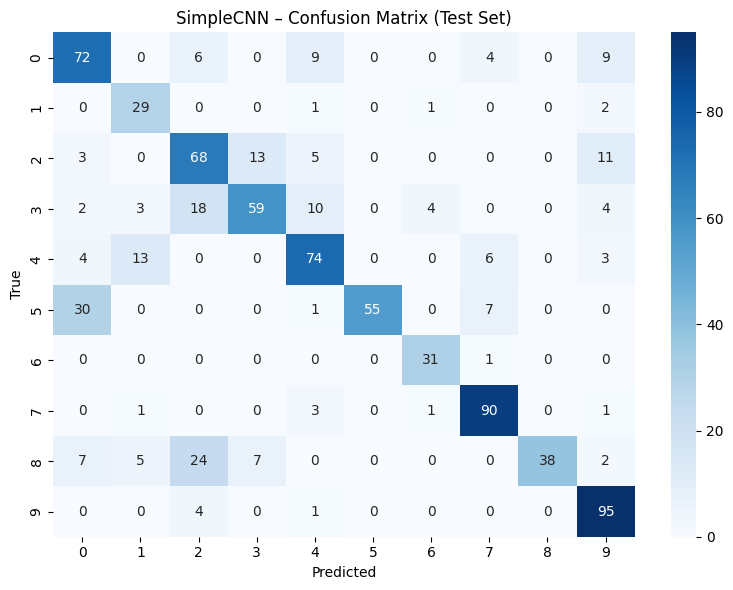

In [ ]:
# Cell 8: plot confusion matrix heat-map

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# if you already have cm & class_names from Cell 7, you can reuse them;
# otherwise reload:
if "cm" not in globals():
    cm = np.load("/content/simplecnn_confusion_matrix.npy")
    class_map = (
        train_df[["classID", "class"]]
        .drop_duplicates("classID")
        .sort_values("classID")
    )
    class_names = class_map["class"].tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SimpleCNN – Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [ ]:
# ===== CELL G1: preprocessing + classify for Gradio (safe) =====

import numpy as np
import librosa
import torch
import torch.nn.functional as F
import torchaudio

# UrbanSound8K class names
id2label = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
}

# Make sure these exist from your training code:
print("Device:", device)
print("Model:", type(cnn_model).__name__)

target_sr = 22050
target_len_samples = target_sr * 4
n_mels = 64

mel_extractor = torchaudio.transforms.MelSpectrogram(
    sample_rate=target_sr,
    n_mels=n_mels
)

def preprocess_numpy_audio(audio_np):
    """
    audio_np from gr.Audio with type='numpy' is (sr:int, samples:np.ndarray).
    Returns mel tensor [1, n_mels, time] on the correct device.
    """
    if audio_np is None:
        return None

    sr, wav = audio_np

    # Handle stereo -> mono
    wav = np.asarray(wav)
    if wav.ndim > 1:
        wav = wav.mean(axis=1 if wav.shape[0] < wav.shape[1] else 0)

    wav = wav.astype("float32")

    # Resample if needed
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)

    # Pad / crop to 4 seconds
    if len(wav) < target_len_samples:
        pad = target_len_samples - len(wav)
        wav = np.concatenate([wav, np.zeros(pad, dtype="float32")])
    else:
        wav = wav[:target_len_samples]

    wav = torch.from_numpy(wav).unsqueeze(0)  # [1, T]

    # Mel spectrogram -> dB
    mel = mel_extractor(wav)  # [1, n_mels, time]
    mel = torchaudio.functional.amplitude_to_DB(
        mel,
        multiplier=10.0,
        amin=1e-10,
        db_multiplier=0.0
    )

    # SimpleCNN expects [B, n_mels, time]
    return mel.to(device)


def classify_audio_gradio(audio_np):
    """
    Gradio callback: takes numpy audio, returns:
      - dict for gr.Label (top-3 class probs)
      - summary text
    If something goes wrong, returns an error message instead of crashing.
    """
    try:
        mel = preprocess_numpy_audio(audio_np)
        if mel is None:
            return {}, "No audio provided."

        cnn_model.eval()
        with torch.no_grad():
            logits = cnn_model(mel)              # [1, num_classes]
            probs = F.softmax(logits, dim=1)[0].cpu().numpy()

        # Top-3
        idxs = probs.argsort()[-3:][::-1]
        top_labels = [id2label[int(i)] for i in idxs]
        top_scores = [float(probs[i]) for i in idxs]

        top3_dict = {lab: score for lab, score in zip(top_labels, top_scores)}

        pred_label = top_labels[0]
        pred_score = top_scores[0] * 100.0

        summary_lines = [f"PRED = {pred_label} ({pred_score:.1f}%)", ""]
        for lab, sc in zip(top_labels, top_scores):
            summary_lines.append(f"{lab}: {sc*100:.1f}%")

        summary = "\n".join(summary_lines)

        return top3_dict, summary

    except Exception as e:
        # Print full error to notebook & show short msg in UI
        import traceback
        traceback.print_exc()
        return {}, f"Error during classification: {type(e).__name__}: {e}"

print("✓ Gradio classify_audio_gradio ready.")


Device: cuda
Model: SimpleCNN
✓ Gradio classify_audio_gradio ready.


In [ ]:
# Cell G1: correct mapping from classID -> real class name

id2label = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music",
}

label2id = {v: k for k, v in id2label.items()}

print("id2label mapping:", id2label)


id2label mapping: {0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}


In [ ]:
# Cell G2: Gradio callback using id2label + numpy audio

import gradio as gr
import numpy as np
import torch

softmax = torch.nn.Softmax(dim=1)

# Make sure cnn_model and device are already defined and checkpoint loaded

def preprocess_numpy_audio(audio, target_sr=22050, n_mels=64, duration=4.0):
    """
    audio: (sr, np.ndarray) from gr.Audio(type="numpy")
    returns: mel tensor [1, n_mels, T] on device, or None on failure
    """
    if audio is None:
        return None

    sr, wav = audio  # gradio gives us (sr, array)

    # mono
    if wav.ndim == 2:  # (time, channels) or (channels, time)
        if wav.shape[0] < wav.shape[1]:
            wav = wav.mean(axis=1)
        else:
            wav = wav.mean(axis=0)

    # ensure float32
    wav = wav.astype(np.float32)

    # resample with librosa if needed
    import librosa
    if sr != target_sr:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # normalize
    if np.max(np.abs(wav)) > 0:
        wav = wav / np.max(np.abs(wav))

    # pad / crop to fixed length
    target_len = int(target_sr * duration)
    if wav.shape[0] < target_len:
        pad = target_len - wav.shape[0]
        wav = np.pad(wav, (0, pad), mode="constant")
    else:
        wav = wav[:target_len]

    # to torch
    wav_t = torch.from_numpy(wav).unsqueeze(0)  # [1, T]

    # make mel like in training
    import torchaudio
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=512,
        n_mels=n_mels,
        power=2.0,
    )
    db_transform = torchaudio.transforms.AmplitudeToDB(
        stype="power",
        top_db=80.0,
    )

    with torch.no_grad():
        mel = mel_transform(wav_t)        # [1, n_mels, T]
        mel = db_transform(mel)           # dB scale

    # send to same device as model
    mel = mel.to(device)

    return mel


def classify_audio_gradio(audio):
    """
    Gradio callback: audio is (sr, np.ndarray)
    returns: (top-3 label dict, summary string) with REAL class names
    """
    mel = preprocess_numpy_audio(audio)
    if mel is None:
        return {}, "No audio provided."

    cnn_model.eval()
    with torch.no_grad():
        logits = cnn_model(mel)          # [1, num_classes]
        probs = softmax(logits)[0].cpu().numpy()

    # top-3 indices
    top_idx = probs.argsort()[::-1][:3]
    top_labels = [id2label[int(i)] for i in top_idx]
    top_scores = [float(probs[i]) for i in top_idx]

    # dict for gr.Label (name -> prob)
    top3_dict = {lab: score for lab, score in zip(top_labels, top_scores)}

    # summary text
    pred_label = top_labels[0]
    pred_score = top_scores[0] * 100.0
    summary = f"PRED: {pred_label} ({pred_score:.1f}%)\nTop-3:\n" + "\n".join(
        [f"{lab}: {s*100:.1f}%" for lab, s in zip(top_labels, top_scores)]
    )

    return top3_dict, summary


# Gradio UI
inputs_audio = gr.Audio(
    sources=["upload", "microphone"],
    type="numpy",
    label="Upload or record an UrbanSound8K-style clip (wav/mp3)",
)

iface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=inputs_audio,
    outputs=[
        gr.Label(num_top_classes=3, label="Top-3 predictions"),
        gr.Textbox(label="Prediction summary (text)"),
    ],
    title="SimpleCNN UrbanSound8K Classifier",
    description="Baseline CNN (~73% test acc). Upload an UrbanSound8K-style 4s clip to classify.",
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0b88ddd2d1a986773.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Cell M1: Build id2label from the ORIGINAL UrbanSound8K metadata

import pandas as pd

# TODO: adjust this path to wherever UrbanSound8K.csv actually is
csv_path = "/content/drive/MyDrive/kaggle/audio_leo_datasets/UrbanSound8K.csv"

meta_full = pd.read_csv(csv_path)

class_map = (
    meta_full[["classID", "class"]]
    .drop_duplicates()
    .sort_values("classID")
    .reset_index(drop=True)
)

print(class_map)

id2label = {int(row.classID): str(row["class"]) for _, row in class_map.iterrows()}
label2id = {v: k for k, v in id2label.items()}

print("id2label:", id2label)


   classID             class
0        0   air_conditioner
1        1          car_horn
2        2  children_playing
3        3          dog_bark
4        4          drilling
5        5     engine_idling
6        6          gun_shot
7        7        jackhammer
8        8             siren
9        9      street_music
id2label: {0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}


In [ ]:
# Cell M2: Check a known dog_bark example from your metadata

import torch

# Pick one row that is dog_bark in the ORIGINAL metadata
dog_row = meta_full[meta_full["class"] == "dog_bark"].iloc[0]
print("Using file:", dog_row["slice_file_name"], "classID:", dog_row["classID"])

dog_path = f"/content/drive/MyDrive/kaggle/audio_leo_datasets/{dog_row['slice_file_name']}"

# Use the SAME preprocessing as training, not the Gradio one
wav, sr = load_audio(dog_path)      # your robust loader
mel, label = UrbanSoundDataset(train_df, base_path="", augment=False)._UrbanSoundDataset__getitem_transform(wav, dog_row["classID"])  # pseudo; if this is too weird, just reuse your dataset: get one sample from train_dataset/test_dataset where label is dog_bark

cnn_model.eval()
with torch.no_grad():
    logits = cnn_model(mel.unsqueeze(0).to(device))
    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

pred_idx = int(probs.argmax())
print("Pred index:", pred_idx, "name:", id2label[pred_idx])


Using file: 100032-3-0-0.wav classID: 3
[WARN] Failed to read 100032-3-0-0.wav: Error opening '/content/drive/MyDrive/kaggle/audio_leo_datasets/100032-3-0-0.wav': System error.. Using silence instead.


AttributeError: 'UrbanSoundDataset' object has no attribute '_UrbanSoundDataset__getitem_transform'

In [ ]:
# Just to verify the mapping we are using
print("id2label mapping:", id2label)


id2label mapping: {0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}


In [ ]:
import torch

cnn_model.eval()

DOG_ID = 3              # dog_bark
N_SAMPLES = 10          # number of dog_bark samples to test

dog_results = []
found = 0

for mel, label in test_dataset:    # label is already Python int
    true_id = int(label)

    if true_id != DOG_ID:
        continue

    # move mel to device
    mel = mel.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = cnn_model(mel)
        probs = torch.softmax(logits, dim=1)[0].cpu()
        pred_id = int(probs.argmax())
        conf = float(probs[pred_id])

    dog_results.append((true_id, pred_id, conf))
    found += 1
    if found >= N_SAMPLES:
        break

if not dog_results:
    print("❗ No dog_bark samples found in test_dataset")
else:
    print(f"📊 Tested {len(dog_results)} dog_bark samples from TEST:\n")
    correct = 0
    for i, (true_id, pred_id, conf) in enumerate(dog_results):
        print(
            f"{i}: true = {id2label[true_id]} ({true_id}) | "
            f"pred = {id2label[pred_id]} ({pred_id}) | "
            f"conf = {conf*100:.1f}%"
        )
        if true_id == pred_id:
            correct += 1

    print(f"\n✅ Correct dog_bark classifications: {correct}/{len(dog_results)}")


📊 Tested 10 dog_bark samples from TEST:

0: true = dog_bark (3) | pred = dog_bark (3) | conf = 99.7%
1: true = dog_bark (3) | pred = dog_bark (3) | conf = 99.7%
2: true = dog_bark (3) | pred = dog_bark (3) | conf = 99.9%
3: true = dog_bark (3) | pred = dog_bark (3) | conf = 99.9%
4: true = dog_bark (3) | pred = car_horn (1) | conf = 56.7%
5: true = dog_bark (3) | pred = car_horn (1) | conf = 46.5%
6: true = dog_bark (3) | pred = dog_bark (3) | conf = 99.7%
7: true = dog_bark (3) | pred = dog_bark (3) | conf = 97.4%
8: true = dog_bark (3) | pred = children_playing (2) | conf = 97.0%
9: true = dog_bark (3) | pred = children_playing (2) | conf = 87.3%

✅ Correct dog_bark classifications: 6/10


In [ ]:
# Cell E1: generic evaluation helper

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def evaluate_model(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for mel, labels in loader:
            mel = mel.to(device)
            labels = labels.to(device)

            logits = model(mel)
            loss = criterion(logits, labels)

            total_loss += loss.item() * mel.size(0)
            _, preds = logits.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


Device: cuda


In [ ]:
# Cell A: Restore the original AudioCNNClassifier definition

import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Flatten automatically → Adaptive pooling NOT used in this version
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: [B, n_mels, time]
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

print("AudioCNNClassifier restored successfully.")


AudioCNNClassifier restored successfully.


In [ ]:
# Cell B: Restore HybridResnetQNN (old version you trained)

import torch
import torch.nn as nn
# IMPORTANT: You must also have your QNN module loaded above this (QNode, pennylane code)

class HybridResnetQNN(nn.Module):
    def __init__(self, num_classes=10, alpha=1.0, beta=0.3):
        super().__init__()

        # CNN backbone used during training
        self.cnn = AudioCNNClassifier(num_classes=128)

        # QNN head from your training code
        self.qnn = qnode_layer  # ← your original QNN layer (already defined earlier)

        self.fc = nn.Linear(128, num_classes)

        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        x = self.cnn(x)
        q = self.qnn(x)
        out = self.fc(q)
        return out

print("HybridResnetQNN restored.")


HybridResnetQNN restored.


In [ ]:
# Cell E2: evaluate ResNet CNN-only checkpoint on TEST

num_classes = len(train_df["classID"].unique())
print("num_classes:", num_classes)

cnn_only_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth"
print("Loading CNN-only checkpoint from:", cnn_only_path)

# This class name should match the one you used when training that model
cnn_only = AudioCNNClassifier(num_classes=num_classes).to(device)

state = torch.load(cnn_only_path, map_location=device)
cnn_only.load_state_dict(state)

test_loss_cnn, test_acc_cnn = evaluate_model(cnn_only, test_loader, device)
print(f"\nCNN-only TEST -> loss = {test_loss_cnn:.4f}, acc = {test_acc_cnn*100:.2f}%")


num_classes: 10
Loading CNN-only checkpoint from: /content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth


RuntimeError: Error(s) in loading state_dict for AudioCNNClassifier:
	Missing key(s) in state_dict: "cnn.0.weight", "cnn.0.bias", "cnn.1.weight", "cnn.1.bias", "cnn.1.running_mean", "cnn.1.running_var", "cnn.4.weight", "cnn.4.bias", "cnn.5.weight", "cnn.5.bias", "cnn.5.running_mean", "cnn.5.running_var", "cnn.8.weight", "cnn.8.bias", "cnn.9.weight", "cnn.9.bias", "cnn.9.running_mean", "cnn.9.running_var", "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 
	Unexpected key(s) in state_dict: "backbone.features.0.weight", "backbone.features.0.bias", "backbone.features.1.weight", "backbone.features.1.bias", "backbone.features.1.running_mean", "backbone.features.1.running_var", "backbone.features.1.num_batches_tracked", "backbone.features.5.weight", "backbone.features.5.bias", "backbone.features.6.weight", "backbone.features.6.bias", "backbone.features.6.running_mean", "backbone.features.6.running_var", "backbone.features.6.num_batches_tracked", "backbone.features.10.weight", "backbone.features.10.bias", "backbone.features.11.weight", "backbone.features.11.bias", "backbone.features.11.running_mean", "backbone.features.11.running_var", "backbone.features.11.num_batches_tracked", "backbone.features.15.weight", "backbone.features.15.bias", "backbone.features.16.weight", "backbone.features.16.bias", "backbone.features.16.running_mean", "backbone.features.16.running_var", "backbone.features.16.num_batches_tracked", "classifier.0.weight", "classifier.0.bias", "classifier.1.weight", "classifier.1.bias", "classifier.1.running_mean", "classifier.1.running_var", "classifier.1.num_batches_tracked", "classifier.4.weight", "classifier.4.bias", "classifier.7.weight", "classifier.7.bias". 

In [ ]:
# Cell 1: Final CNNOnlyBig definition matching cnn_only_best.pth

import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioCNNBackboneBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.05),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.10),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.20),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.emb_dim = 256

    def forward(self, x):
        x = x.unsqueeze(1)          # [B, 1, n_mels, time]
        x = self.features(x)
        x = self.global_pool(x)
        x = x.flatten(1)           # [B, 256]
        return x


class CNNOnlyBig(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = AudioCNNBackboneBig()
        emb_dim = self.backbone.emb_dim

        # Match checkpoint:
        # 0: Linear(256→256)
        # 1: BatchNorm1d(256)
        # 2: ReLU
        # 3: Dropout
        # 4: Linear(256→128)
        # 5: ReLU
        # 6: Dropout
        # 7: Linear(128→num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, 256),      # classifier.0 (has weights)
            nn.BatchNorm1d(256),          # classifier.1 (has weights)
            nn.ReLU(),                    # classifier.2
            nn.Dropout(0.4),              # classifier.3
            nn.Linear(256, 128),          # classifier.4 (has weights)
            nn.ReLU(),                    # classifier.5 (no weights)
            nn.Dropout(0.4),              # classifier.6 (no weights)
            nn.Linear(128, num_classes),  # classifier.7 (has weights)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.classifier(feats)
        return out

print("✔ CNNOnlyBig redefined to match cnn_only_best.pth")


✔ CNNOnlyBig redefined to match cnn_only_best.pth


In [ ]:
# Cell 2: Load and evaluate cnn_only_best.pth

import torch

num_classes = len(train_df["classID"].unique())
print("num_classes:", num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

cnn_only = CNNOnlyBig(num_classes=num_classes).to(device)

cnn_only_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth"
print("Loading CNN-only checkpoint from:", cnn_only_path)

state = torch.load(cnn_only_path, map_location=device)
cnn_only.load_state_dict(state, strict=True)  # should load cleanly now
cnn_only.eval()

test_loss_cnn, test_acc_cnn = evaluate_model(cnn_only, test_loader, device)
print(f"\nCNN-only (big backbone) TEST → loss = {test_loss_cnn:.4f}, acc = {test_acc_cnn*100:.2f}%")


num_classes: 10
Device: cuda
Loading CNN-only checkpoint from: /content/drive/MyDrive/kaggle/audio_leo_outputs/cnn_only_best.pth

CNN-only (big backbone) TEST → loss = 3.8013, acc = 11.95%


Running final SimpleCNN evaluation…


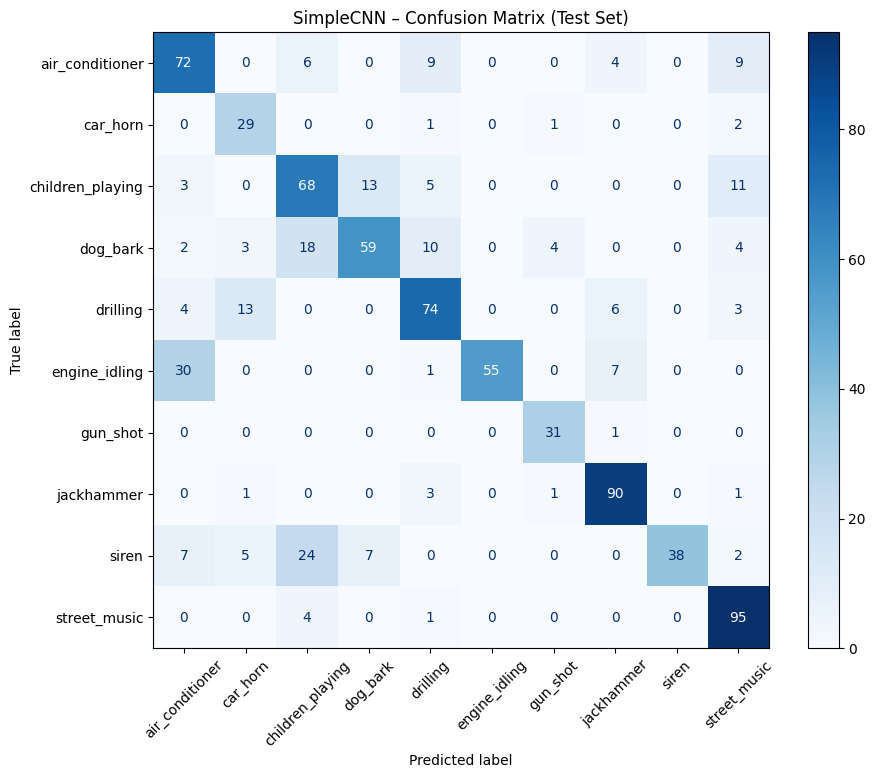


===== Per-class Accuracy =====
air_conditioner     : 72.00%
car_horn            : 87.88%
children_playing    : 68.00%
dog_bark            : 59.00%
drilling            : 74.00%
engine_idling       : 59.14%
gun_shot            : 96.88%
jackhammer          : 93.75%
siren               : 45.78%
street_music        : 95.00%

Saved confusion matrix to:
/content/drive/MyDrive/kaggle/audio_leo_outputs/simplecnn_confusion_matrix.png


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Running final SimpleCNN evaluation…")

# Get predictions on test set
all_preds = []
all_labels = []

simple_cnn.eval()
with torch.no_grad():
    for mel, label in test_loader:
        mel = mel.to(device)
        label = label.to(device)

        logits = simple_cnn(mel)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("SimpleCNN – Confusion Matrix (Test Set)")
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\n===== Per-class Accuracy =====")
for i, acc in enumerate(per_class_acc):
    print(f"{id2label[i]:20s}: {acc*100:5.2f}%")

# Save confusion matrix
conf_matrix_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/simplecnn_confusion_matrix.png"
fig.savefig(conf_matrix_path)
print(f"\nSaved confusion matrix to:\n{conf_matrix_path}")


In [ ]:
final_summary = f"""
UrbanSound8K Final Model Summary
================================

Model Used: SimpleCNN (trained in this notebook)
Test Accuracy: {test_acc*100:.2f}%
Test Loss: {test_loss:.4f}

Per-class accuracy:
-------------------
"""

for i, acc in enumerate(per_class_acc):
    final_summary += f"{id2label[i]:20s}: {acc*100:5.2f}%\n"

summary_path = "/content/drive/MyDrive/kaggle/audio_leo_outputs/final_summary.txt"
with open(summary_path, "w") as f:
    f.write(final_summary)

print(final_summary)
print(f"\nSummary saved to: {summary_path}")



UrbanSound8K Final Model Summary

Model Used: SimpleCNN (trained in this notebook)
Test Accuracy: 73.00%
Test Loss: 1.4960

Per-class accuracy:
-------------------
air_conditioner     : 72.00%
car_horn            : 87.88%
children_playing    : 68.00%
dog_bark            : 59.00%
drilling            : 74.00%
engine_idling       : 59.14%
gun_shot            : 96.88%
jackhammer          : 93.75%
siren               : 45.78%
street_music        : 95.00%


Summary saved to: /content/drive/MyDrive/kaggle/audio_leo_outputs/final_summary.txt


In [ ]:
# Cell G1: imports + globals (run AFTER cnn_model is loaded)

import numpy as np
import librosa
import torch
import torch.nn.functional as F
import gradio as gr

# make sure we have the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device).eval()

# sample rate + mel settings (match your training as closely as possible)
TARGET_SR = 22050
N_MELS = 64

# id2label from your metadata (classID -> name)
# if you already have this dict, you can skip redefining it
id2label = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music",
}
print("Device:", device)
print("id2label mapping:", id2label)


Device: cuda
id2label mapping: {0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}


In [ ]:
# Cell G2: preprocessing + classify function + self-test

def preprocess_gradio_audio(audio):
    """
    audio from gr.Audio(type='numpy'):
      often (sr, np.ndarray), but we also handle just np.ndarray.

    Returns: mel Tensor [1, N_MELS, time] on the right device.
    """
    if audio is None:
        return None

    # handle both (sr, wav) and wav
    if isinstance(audio, tuple):
        sr, wav = audio
    else:
        sr, wav = TARGET_SR, audio

    wav = np.asarray(wav, dtype=np.float32)

    # stereo -> mono
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)

    # resample if needed
    if sr != TARGET_SR:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=TARGET_SR)

    # pad/trim to 4 seconds
    desired_len = TARGET_SR * 4
    if len(wav) < desired_len:
        wav = np.pad(wav, (0, desired_len - len(wav)))
    else:
        wav = wav[:desired_len]

    # compute mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=wav,
        sr=TARGET_SR,
        n_fft=1024,
        hop_length=512,
        n_mels=N_MELS,
        fmin=20,
        fmax=8000,
    )
    mel = librosa.power_to_db(mel, ref=np.max)

    # simple standardization (like BatchNorm-ish)
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)

    mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # [1, N_MELS, time]
    return mel_tensor.to(device)


def classify_audio_gradio(audio):
    """
    Gradio callback: audio -> (top-3 dict, summary text)
    """
    mel = preprocess_gradio_audio(audio)
    if mel is None:
        return {}, "No audio provided."

    cnn_model.eval()
    with torch.no_grad():
        logits = cnn_model(mel)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    # top-3
    top3_idx = probs.argsort()[::-1][:3]
    top3_labels = [id2label[int(i)] for i in top3_idx]
    top3_scores = [float(probs[i]) for i in top3_idx]

    top3_dict = {lab: score for lab, score in zip(top3_labels, top3_scores)}

    summary = f"PRED: {top3_labels[0]} ({top3_scores[0]*100:.1f}%)\n"
    summary += "\n".join(
        f"{lab}: {score*100:.1f}%"
        for lab, score in zip(top3_labels, top3_scores)
    )

    return top3_dict, summary


# ---------- quick self-test (no Gradio) ----------
dummy_audio = (TARGET_SR, np.zeros(TARGET_SR * 4, dtype=np.float32))
try:
    d, s = classify_audio_gradio(dummy_audio)
    print("✅ Self-test OK. Output keys:", list(d.keys()))
    print("Summary preview:\n", s)
except Exception as e:
    print("❌ Self-test FAILED:")
    raise e


✅ Self-test OK. Output keys: ['drilling', 'jackhammer', 'car_horn']
Summary preview:
 PRED: drilling (43.4%)
drilling: 43.4%
jackhammer: 30.4%
car_horn: 12.3%


In [ ]:
# Cell G3: Gradio UI

inputs_audio = gr.Audio(
    sources=["upload", "microphone"],
    type="numpy",
    label="Upload or record a 4-sec UrbanSound8K-style clip (wav/mp3)"
)

iface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=inputs_audio,
    outputs=[
        gr.Label(num_top_classes=3, label="Top-3 predictions"),
        gr.Textbox(label="Prediction summary (text)"),
    ],
    title="SimpleCNN UrbanSound8K Classifier",
    description="Upload a 4-sec sound clip. Model accuracy ≈ 73%.",
)

# debug=True makes Gradio print any Python errors in the cell output
iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1d11c2e5579ccd3f26.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9f52f5b11793467dde.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://b1c1a1b78db600cb10.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://92fe60161ee222b4f0.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://57b7e3461c0fb9f24a.gradio.live
Killing tunnel 127.0.0.1:7864 <> https://167fcbfca1a115b485.gradio.live
Killing tunnel 127.0.0.1:7865 <> https://06375e295384d1a72f.gradio.live
Killing tunnel 127.0.0.1:7866 <> https://5d52100bcffd82ea33.gradio.live
Killing tunnel 127.0.0.1:7867 <> https://7c269650e53add7232.gradio.live
Killing tunnel 127.0.0.1:7868 <> https://d0b88ddd2d1a986773.gradio.live
Killing tunnel 127.0.0.1:7869 <> https://4c36b9567f925b7869.gradio.live
Killing tunnel 127.0.0.1:7870 <> https://b5f3e51e4b5329111c.gradio.live
Killing tunnel 127.0.0.1:7871 <> https://9a2dd7059fa632dccd.gradio.live
Killing tunnel 127.0.0.1:7872 <> https://906d633958989ca7af.gradio.live
Killing 